### Reinforcement learning & llms 

en lugar de usar labeled data usamos recompensas para guiar el proceso de aprendizaje

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import torch
import torch.nn as nn
import re
import chess
import chess.engine
import chess.svg
from peft import LoraConfig, get_peft_model, TaskType
from IPython.display import display, SVG

cargamos el dataset y el modelo: Qwen2.5-3b

In [ ]:


HF_DATASET_NAME = "bonna46/Chess-FEN-and-NL-Format-30K-Dataset"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-3B-Instruct")
model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-3B-Instruct",
    torch_dtype=torch.bfloat16
)
model.to(device)
model.gradient_checkpointing_enable()



las capas lineales antes de q,k,v y output es donde agregamos los adapters lora

In [ ]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


dataset = load_dataset(HF_DATASET_NAME)
print("Dataset sample:", dataset['train'][0])

representamos al llm dentro de una clase policy 

In [ ]:

class Policy(nn.Module):
    def __init__(self, pretrained_model, gamma=0.99):
        super(Policy, self).__init__()
        self.model = pretrained_model
        self.tokenizer = tokenizer
        self.gamma = gamma
        self.policy_history = []
        self.reward_episode = []

    def forward(self, input_ids):
        outputs = self.model(input_ids)
        logits = outputs.logits[:, -1, :]
        logits = logits.float()
        probs = nn.Softmax(dim=-1)(logits)
        return probs

    def select_action(self, input_ids):
        probs = self.forward(input_ids)
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        self.policy_history.append(log_prob)
        return action

funciones de ayuda

In [ ]:
def is_valid_move(board, move_uci):
    try:
        move = chess.Move.from_uci(move_uci)
        return move in board.legal_moves
    except ValueError:
        return False

def get_stockfish_eval(board, depth=15):
    try:
        engine = chess.engine.SimpleEngine.popen_uci("/usr/games/stockfish")
        info = engine.analyse(board, chess.engine.Limit(depth=depth))
        score = info["score"].pov(board.turn).score(mate_score=10000)
        best_move = info["pv"][0] if "pv" in info else None
        engine.quit()
        return score, best_move.uci() if best_move else None
    except Exception as e:
        print(f"Error during Stockfish evaluation: {e}")
        return None, None

def format_reward_function(completion_str: str) -> float:
    try:
        regex = r"<pensando>(.*?)</pensando>"
        match = re.search(regex, completion_str, re.DOTALL)
        has_opening = "<pensando>" in completion_str
        has_closing = "</pensando>" in completion_str

        if match and match.group(1).strip():
            return 1.0
        elif has_opening and has_closing:
            return 0.5
        elif has_opening or has_closing:
            return 0.25
        return 0.0
    except Exception as e:
        print(f"Error in format_reward_function: {e}")
        return 0.0


def extract_move(completion_str: str) -> str:
    """Extract the move from <movimiento> tags or raw text, ensuring UCI format."""
    try:
       
        regex = r"<movimiento>(.*?)</movimiento>"
        match = re.search(regex, completion_str, re.DOTALL)
        if match and match.group(1).strip():
            move = match.group(1).strip()
            if re.match(r"^[a-h][1-8][a-h][1-8]$", move):
                return move
            print(f"Invalid UCI format in <movimiento>: {move}")
            return None

        # Fallback: search for UCI-like strings
        uci_pattern = r"\b[a-h][1-8][a-h][1-8]\b"
        uci_matches = re.findall(uci_pattern, completion_str)
        if uci_matches:
            return uci_matches[-1]
        print("No valid UCI move found in output")
        return None
    except Exception as e:
        print(f"Error in extract_move: {e}")
        return None

def get_movement_reward(board, move_uci, stockfish_move):
    reward = 0.0
    if move_uci:
        valid_move = is_valid_move(board, move_uci)
        if valid_move:
            reward += 1.0
            board_copy = board.copy()
            board_copy.push(chess.Move.from_uci(move_uci))
            score, _ = get_stockfish_eval(board_copy)
            if score is not None:
                reward += score / 100.0
            if move_uci == stockfish_move:
                reward += 0.5
        else:
            reward -= 0.5
    else:
        reward -= 1.0
    return reward



def calculate_reward(format_reward: float, movement_reward: float) -> float:
    return min(2.0, format_reward + 1.5 * movement_reward)

def display_board_svg(board, move_uci=None, episode=None):
    try:
 
        svg = chess.svg.board(board=board, size=400)
        print(f"Episode {episode} - Initial Board:")
        display(SVG(svg)) 

        with open(f"board_initial_ep{episode}.svg", "w") as f:
            f.write(svg)


        if move_uci and is_valid_move(board, move_uci):
            board_copy = board.copy()
            board_copy.push(chess.Move.from_uci(move_uci))
            svg = chess.svg.board(board=board_copy, size=400)
            print(f"Episode {episode} - Board after move {move_uci}:")
            display(SVG(svg))
            with open(f"board_after_move_ep{episode}.svg", "w") as f:
                f.write(svg)
    except Exception as e:
        print(f"Error generating SVG for episode {episode}: {e}")

entrenamiento principal,usando REINFORCE cambiamos los parametros del modelo para maximizar la recompensa esperada
##### 1: usar el llm para jugar un "episodio" y ganar una recompensa. 
##### 2: al recibir una recompensa, calculamos el gradiente entre la recompensa esperada y los parametros del modelo
##### 3: usamos -loss para aumentar la probabilidad de seleccionar esa accion en el futuro

Using device: cuda


Sliding Window Attention is enabled but not implemented for `eager`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 7,372,800 || all params: 3,093,311,488 || trainable%: 0.2383
Dataset sample: {'FEN': 'rnb2k1q/3ppp2/7b/1N3Bpr/QP3Pn1/P7/2PPN1R1/1RBK4 b - - 2 24', 'Next move': 'a8a4', 'FEN + Next move': 'FEN state: rnb2k1q/3ppp2/7b/1N3Bpr/QP3Pn1/P7/2PPN1R1/1RBK4 b - - 2 24 ; Best move: a8a4', 'NL Format of FEN': 'The current state of the chess board is: Black rook at a8, black knight at b8, black bishop at c8, black king at f8 and black queen at h8. Black pawn at d7, black pawn at e7 and black pawn at f7. Black bishop at h6. White knight at b5, white bishop at f5, black pawn at g5 and black rook at h5. White queen at a4, white pawn at b4, white pawn at f4 and black knight at g4. White pawn at a3. White pawn at c2, white pawn at d2, white knight at e2 and white rook at g2. White rook at b1, white bishop at c1 and white king at d1. Both players have exhausted their castles. Half move number is 2. Full move number is 24. Black to move.'}
Optimizer targeting 7372800 trainable parameters.

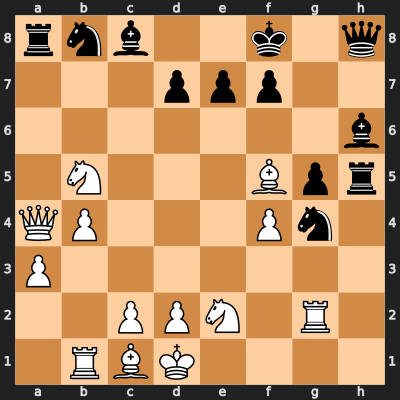


Episode 0:
FEN: rnb2k1q/3ppp2/7b/1N3Bpr/QP3Pn1/P7/2PPN1R1/1RBK4 b - - 2 24
Generated Text:
"<pensando></pensando>Given the FEN position rnb2k1q/3ppp2/7b/1N3Bpr/QP3Pn1/P7/2PPN1R1/1RBK4 b - - 2 24, the current position is highly defensive for the black side. The key factor is that black has no safe squares for his king and is threatened by the knight on b5 controlling key central squares. Additionally, the white rook on c1 is under threat, which can inform our strategy.\n\nThe knight on b5 is the primary target. The most effective way to eliminate the threat is with g7-g5, which not only removes the knight's control but also weakens the center. After White plays g7-g5, the knight can no longer influence the d-file or the center effectively.\n\n<pensando></pensando>Therefore, the move <movimiento>g7-g5</movimiento> is the best as it directly addresses the key threat and opens up lines for further actions.\n\n<movimiento>g7-g5</movimiento>"
Extracted Move: None
Stockfish Move: h5h1
Format

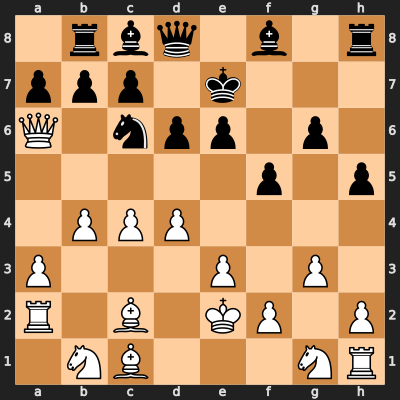


Episode 1:
FEN: 1rbq1b1r/ppp1k3/Q1npp1p1/5p1p/1PPP4/P3P1P1/R1B1KP1P/1NB3NR b - - 1 19
Generated Text:
"<pensando></pensando>After analyzing the FEN position provided, the key to making an optimal move lies in evaluating the sacrifices and threats that the current position allows. The position might be dominated by a strong pawn pressure on one side or indicate a tactical opportunity for a checkmate. Color forces dictate the advantage and possibly the necessity for specific tactical responses. In this specific case, sacrificing a piece to create an attacking position against the opponent's blocked pawn chain could be key. A decisive move highlighted in the position could be a kingside attack from the Rook.</pensando>\n<movimiento></movimiento>g7g5"
Extracted Move: g7g5
Stockfish Move: b7a6
Format Reward: 0.5, Movement Reward: -0.5, Total Reward: -0.25
Invalid UCI format in <movimiento>: Be2
Episode 2 - Initial Board:


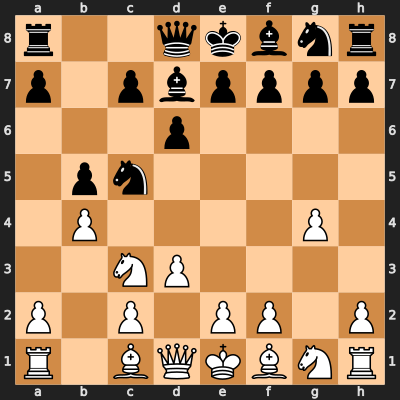


Episode 2:
FEN: r2qkbnr/p1pbpppp/3p4/1pn5/1P4P1/2NP4/P1P1PP1P/R1BQKBNR w KQkq - 1 6
Generated Text:
'<pensando></pensando>\nThe current position shows a slight pressure on the black king. The key to the position might be targeting the Q8 square to pressure the black king. However, the most effective and immediate threat is the threat to the e7 pawn with Bf1-e2. This opening move, combined with potential later threats against the pawn structure and the center, give White an edge in the position.\n<movimiento>Be2</movimiento>'
Extracted Move: None
Stockfish Move: b4c5
Format Reward: 0.5, Movement Reward: -1.0, Total Reward: -1.0
No valid UCI move found in output
Episode 3 - Initial Board:


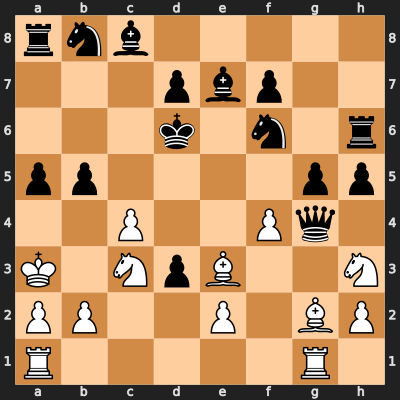


Episode 3:
FEN: rnb5/3pbp2/3k1n1r/pp4pp/2P2Pq1/K1NpB2N/PP2P1BP/R5R1 w - - 0 21
Generated Text:
"<pensando></pensando>Given the position, the best move to consider would be to activate the bishops and create a threat on the opponent's king. Moving the knight to g5, for instance, not only activates the bishop f7 but also puts the opponent's king in check. This could be quite effective since there are likely some weaknesses in the opponent's position that this move can exploit.\n\nConsiderations:\n- The f-file is still not fully protected, which is something the player can leverage.\n- The knight's move also supports the bishop, creating a tactical benefit.\n\n<pseudomove></pseudomove><movimiento></movimiento>ágina5"
Extracted Move: None
Stockfish Move: c3b5
Format Reward: 0.5, Movement Reward: -1.0, Total Reward: -1.0
No valid UCI move found in output
Episode 4 - Initial Board:


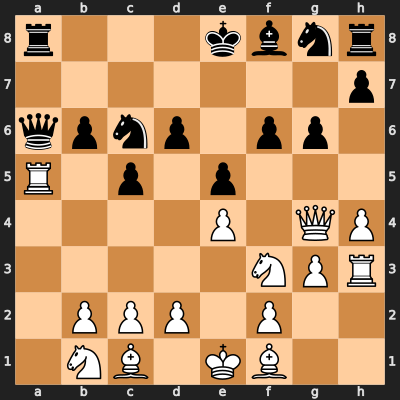


Episode 4:
FEN: r3kbnr/7p/qpnp1pp1/R1p1p3/4P1QP/5NPR/1PPP1P2/1NB1KB2 b kq - 2 12
Generated Text:
"<pensando></pensando>Considering the given FEN, both the king and the queen are under attack. The knight positioned on e7 is in a prime position to disrupt the enemy's plan, especially since the king and queen are close to being in check. The knight on e7, f6, or d6 are all likely to either support the attack or initiate threats to the king. Hiding behind the queen or ignoring the threat would not be an optimal chess strategy.\n\nLet's evaluate moving the knight to f6, as it secures a spot away from the danger but still allows attacking potential at e7. Additionally, f6 is in a more active position compared to d6 or e7. Moving the bishop resulting in e6 or d6 seems less promising as it exposes the king and does not provide clear strategic advantage. In conclusion, moving the knight to f6 is a key defensive move that doesn't compromise the position further.\n\n<movimiento></movimiento>fen:

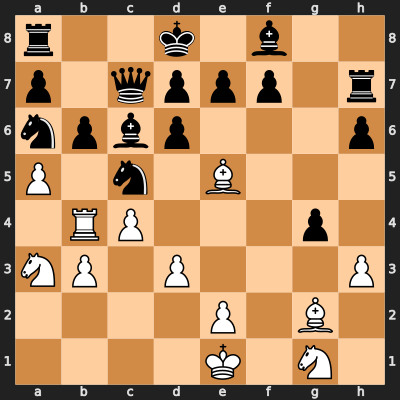


Episode 5:
FEN: r2k1b2/p1qppp1r/npbp3p/P1n1B3/1RP3p1/NP1P3P/4P1B1/4K1N1 w - - 0 24
Generated Text:
"<pensando>\nAnalyzing the given FEN: r2k1b2/p1qppp1r/npbp3p/P1n1B3/1RP3p1/NP1P3P/4P1B1/4K1N1 w - - 24 0. In this position, the white king is under significant threat. The knight on g1 could be cut off due to the pawns on g6 and h6. Therefore, the best move to protect the king and create a space for a queen or pawn to advance is by moving the knight to f2, which also prepares for recapturing with this knight. This move is critical for white's strategy.\n</pensando>\n<movimiento>b1f2></movimiento>"
Extracted Move: None
Stockfish Move: a3b5
Format Reward: 1.0, Movement Reward: -1.0, Total Reward: -0.5
Episode 6 - Initial Board:


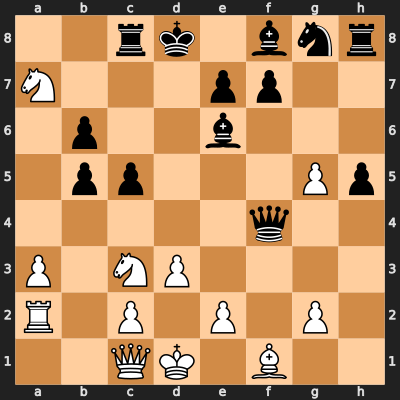


Episode 6:
FEN: 2rk1bnr/N3pp2/1p2b3/1pp3Pp/5q2/P1NP4/R1P1P1P1/2QK1B2 w - - 1 23
Generated Text:
'<pensando></pensando>\n<movimiento>d2d4</movimiento>'
Extracted Move: d2d4
Stockfish Move: c1f4
Format Reward: 0.5, Movement Reward: -0.5, Total Reward: -0.25
No valid UCI move found in output
Episode 7 - Initial Board:


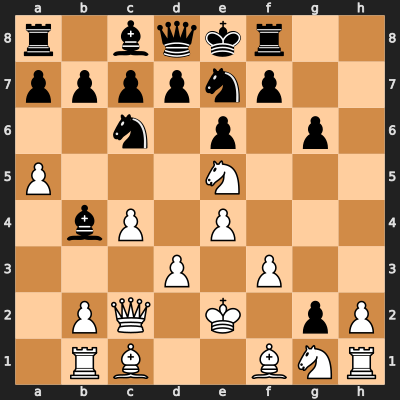


Episode 7:
FEN: r1bqkr2/ppppnp2/2n1p1p1/P3N3/1bP1P3/3P1P2/1PQ1K1pP/1RB2BNR w q - 3 16
Generated Text:
'<pensando></pensando>Given the FEN position r1bqkr2/ppppnp2/2n1p1p1/P3N3/1bP1P3/3P1P2/1PQ1K1pP/1RB2BNR w q - 3 16, the white king bishop at g1 is under immediate threat from the black knight at f6. The best move to prevent this and gain space on the board is to capture the black knight with the white queen. This allows the queen to move to f2, putting pressure on the position with black and opening d-file for a potential pawn push. After the move Qf2.\n\n<movimiento></movimiento>Qf2'
Extracted Move: None
Stockfish Move: f1g2
Format Reward: 0.5, Movement Reward: -1.0, Total Reward: -1.0
No valid UCI move found in output
Episode 8 - Initial Board:


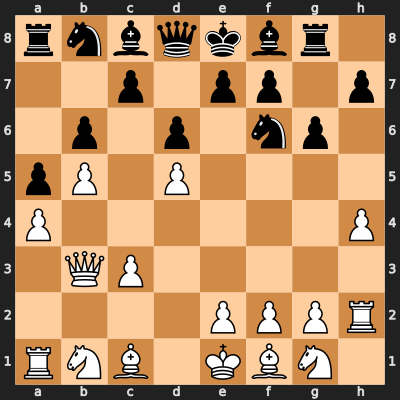


Episode 8:
FEN: rnbqkbr1/2p1pp1p/1p1p1np1/pP1P4/P6P/1QP5/4PPPR/RNB1KBN1 b Qq - 1 9
Generated Text:
'<pensando></pensando>Given the FEN position rnbqkbr1/2p1pp1p/1p1p1np1/pP1P4/P6P/1QP5/4PPPR/RNB1KBN1 b Qq - 1 9, the white queen is blocked behind the knight and cannot easily attack the black queen. The pawns on the a and d files are weak and could be targeted. However, moving the queen can be risky because of potential piece development and check. The best option seems to be to take the black queen with the knight, as it is the only feasible attack in the given position. The knight on e2, which can attack the black queen (b1) on a better angle, is chosen for this move.</pensando>\n<movimiento></movimiento>ne2e6'
Extracted Move: None
Stockfish Move: c8b7
Format Reward: 0.5, Movement Reward: -1.0, Total Reward: -1.0
No valid UCI move found in output
Episode 9 - Initial Board:


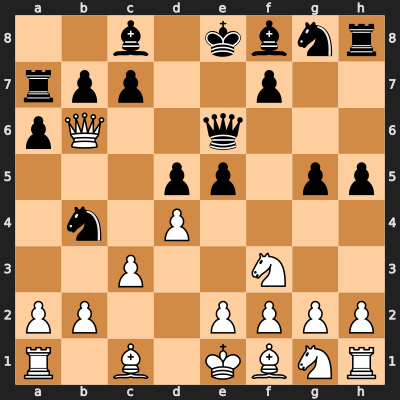


Episode 9:
FEN: 2b1kbnr/rpp2p2/pQ2q3/3pp1pp/1n1P4/2P2N2/PP2PPPP/R1B1KBNR w KQk - 6 11
Generated Text:
"<pensando></pensando>Let's analyze the position carefully.\n\n- The White King (w K) is on the 11th rank. He seemingly has no immediate checkmate threats but faces pressure as Black has several pieces active in the center and along the squares supporting the pawn structure.\n- The presence of key pieces is essential for mobility and pressure. The king's position isn't encircled but should guard any planned castling attempt.\n- White needs to disrupt the Black pawn chain in the center and occupy key squares with their pieces.\n\nConsidering the goals, the best move, aiming to protect the king, control key files, and disrupt pieces, <movimiento></movimiento> e5"
Extracted Move: None
Stockfish Move: b6e6
Format Reward: 0.5, Movement Reward: -1.0, Total Reward: -1.0
No valid UCI move found in output
Episode 10 - Initial Board:


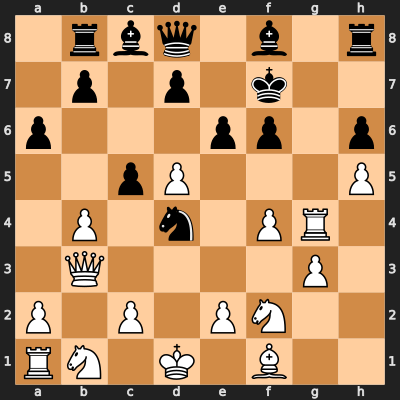


Episode 10:
FEN: 1rbq1b1r/1p1p1k2/p3pp1p/2pP3P/1P1n1PR1/1Q4P1/P1P1PN2/RN1K1B2 w - - 4 20
Generated Text:
"<pensando></pensando>Given the FEN position 1rbq1b1r/1p1p1k2/p3pp1p/2pP3P/1P1n1PR1/1Q4P1/P1P1PN2/RN1K1B2 w - - 4 20, the white player should consider how to exploit the knight's position. Currently, the knight is in d5, which gives it sharp attacking prospects on the board. The king, on e2, if targeted, could become a problem for the white king’s safety. Additionally, the strength of the queen, on e1, along with the bishop on b2 and knight on c1, points towards immediate active play. The position has several checkedmate threats, considering the king is doubled on the queenside (e2, f2).\n\nGiven this, the best move to consider would be to pull the knight off the attack and potentially create a new weakness which promotes piece activity. Moving the knight from d5 to h6 threatens to advance a pawn and puts pressure on the black queen, also setting up a promotion scenario for the kni

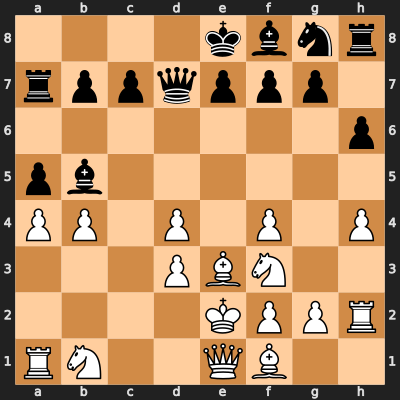


Episode 11:
FEN: 4kbnr/rppqppp1/7p/pb6/PP1P1P1P/3PBN2/4KPPR/RN2QB2 b k - 2 17
Generated Text:
'<pensando>\nThe current position shows a critical central control issue for Black, with lack of pawns and a weak p4c4 pawn. The knight on f3 is under attack from g5 and the surrounding pawns could easily come for it. However, the white king needs to be protected, proving this is a very tactical position. \n\nA strong move for Black would be to recapture with light pieces. The pawn on f6, if brought back to c5, would spur much more tactical play. Thus, sacrificing the pawn on c6 allows the knight back to an active position and stops any immediate central pawn storms. \n</pensando>\n<movimiento>k6c5</movimiento>'
Extracted Move: None
Stockfish Move: a5b4
Format Reward: 1.0, Movement Reward: -1.0, Total Reward: -0.5
Episode 12 - Initial Board:


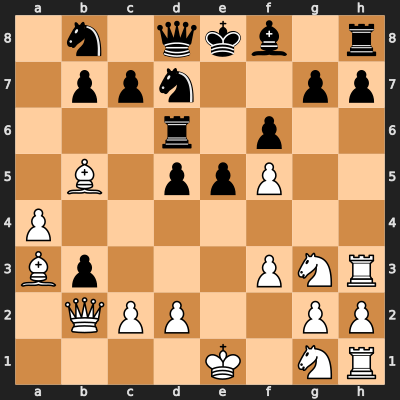


Episode 12:
FEN: 1n1qkb1r/1ppn2pp/3r1p2/1B1ppP2/P7/Bp3PNR/1QPP2PP/4K1NR w k - 1 18
Generated Text:
'<pensando></pensando>Given the FEN 1n1qkb1r/1ppn2pp/3r1p2/1B1ppP2/P7/Bp3PNR/1QPP2PP/4K1NR w k - 1 18, the king is in a dangerous position on g1, and the side to move (white) needs to protect it while also gaining space. A key objective for white could involve moving a piece towards the enemy king and freeing up a square for a potential exchange. The pawn on c4 shows relative weakness, but it is defended by the knight on e2 and better positioned to advance than the pawns on e3 or d4. Aim is to hold the position threatening the enemy king and consolidating the center.</pensando>\n<movimiento></movimiento>g2g3'
Extracted Move: g2g3
Stockfish Move: b2b3
Format Reward: 0.5, Movement Reward: -0.5, Total Reward: -0.25
Episode 13 - Initial Board:


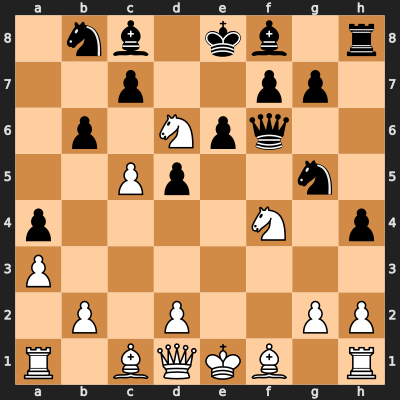


Episode 13:
FEN: 1nb1kb1r/2p2pp1/1p1Npq2/2Pp2n1/p4N1p/P7/1P1P2PP/R1BQKB1R b KQk - 0 15
Generated Text:
"<pensando>\nConsidering the FEN position, the key to analyzing this position efficiently is to understand the current dynamics and weaknesses in the board. The position indicates a slight advantage for Black, who has a pawn on f7 and a slightly active knight on f5. However, the strong position of the white king relative to its own back rank can be unfavorable if not managed well. \n\nGiven Black's piece activity and the lack of weaknesses on the square f7, an insignificant move like 'e7e6' would be defensive. However, Black can aim for strategic activation of his pieces or building a pushing pawn thrust. \n\nIn this scenario, the best move for Black would be to create some more pressure on the center and potentially activate a piece. The move 'g8f6' fulfills this purpose: it pushes a pawn to the sixth rank, weakening the white pawn barrier and potentially forcing a response like 'f6

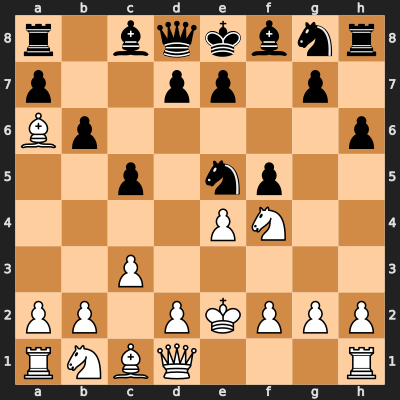


Episode 14:
FEN: r1bqkbnr/p2pp1p1/Bp5p/2p1np2/4PN2/2P5/PP1PKPPP/RNBQ3R w kq - 0 7
Generated Text:
'<pensando>\nIn the given FEN position, the White King (w) is under immediate threat. The best move in this scenario appears to be promoting a pawn to a queen (the strongest piece) to checkmate the Black King (k). Placing the Queen (Q) on f7 threatens Black’s King and potentially results in a quick checkmate. This is the most effective move to capitalize on the current position.\n</pensando>\n<movimiento>kxf7</movimiento>'
Extracted Move: None
Stockfish Move: a6c8
Format Reward: 1.0, Movement Reward: -1.0, Total Reward: -0.5
Invalid UCI format in <movimiento>: ef5
Episode 15 - Initial Board:


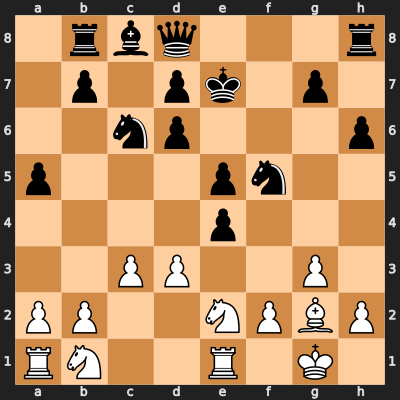


Episode 15:
FEN: 1rbq3r/1p1pk1p1/2np3p/p3pn2/4p3/2PP2P1/PP2NPBP/RN2R1K1 w - - 0 18
Generated Text:
"<pensando>\nIn the given position, the white side has a strong pawn on f6 that could serve as a threat. The pawn on f5 is also well-placed to potentially push and attack the black side's pawn on f7. If white can take control of the f-file, it could put pressure on black's king. Thus, aiming to control the strategic f-file, the best move is to push the f-pawn forward, threatening to capture the pawn on f7 with a f6-f5 advance.\n</pensando>\n<movimiento>ef5</movimiento>"
Extracted Move: None
Stockfish Move: d3e4
Format Reward: 1.0, Movement Reward: -1.0, Total Reward: -0.5
Episode 16 - Initial Board:


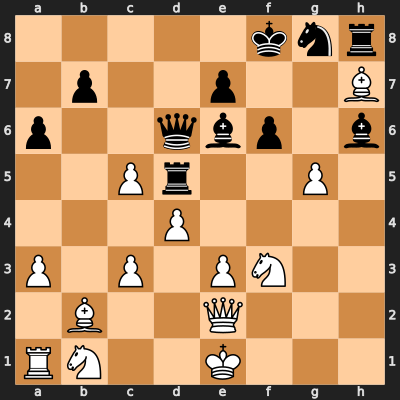


Episode 16:
FEN: 5knr/1p2p2B/p2qbp1b/2Pr2P1/3P4/P1P1PN2/1B2Q3/RN2K3 b Q - 0 25
Generated Text:
'<pensando>\nIn the given position, the Black King is on a critical square which restricts his movements. Additionally, there are significant weak pawns on the e-file and f-file. The knight on g8 can be targeted by white for a potential sacrifice to open a file or create weaknesses. Moving the queen forward to f2 would attack the opposition and potentially open a file. However, moving the queen to f2 exposes the back rank which could be exploited in the endgame. Thus, the best option seems to be to move the knight to f8, which not only attacks a key square on the throne but also puts pressure on the Bishop on f2. This prepares for future pawn moves or potentially a breakthrough in the center.\n</pensando>\n<movimiento>f8f6</movimiento>'
Extracted Move: f8f6
Stockfish Move: d6g3
Format Reward: 1.0, Movement Reward: -0.5, Total Reward: 0.25
Episode 17 - Initial Board:


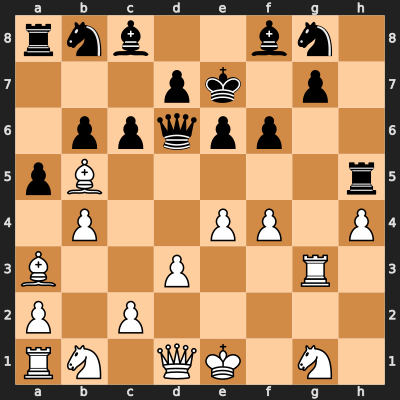


Episode 17:
FEN: rnb2bn1/3pk1p1/1ppqpp2/pB5r/1P2PP1P/B2P2R1/P1P5/RN1QK1N1 b Q - 1 17
Generated Text:
"<pensando>\nIn the given position, the black king is isolated in the center and under attack by the white queen. Castling is not a viable option for the black king as it would place the king in check. Therefore, the best move is the one that defends the king and threatens the queen. The move 'e7e5' is the most strategic, as it moves the dark-squared bishop (which could have threats) away from the backRank and clears the diagonal for the black king to escape threats in the future moves. The center pawns are also advanced, improving control over the center.\n</pensando>\n<movimiento>e7e5</movimiento>"
Extracted Move: e7e5
Stockfish Move: d6f4
Format Reward: 1.0, Movement Reward: -0.5, Total Reward: 0.25
No valid UCI move found in output
Episode 18 - Initial Board:


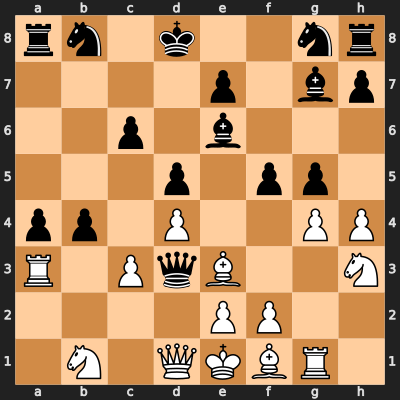


Episode 18:
FEN: rn1k2nr/4p1bp/2p1b3/3p1pp1/pp1P2PP/R1PqB2N/4PP2/1N1QKBR1 w - - 0 16
Generated Text:
'<pensando>\nIn the current position, the white king is under significant threat from the black knight on c7. Additionally, the white rook on a1 is under pressure from the black pawn on c7, and the bishop pair allows for active piece play. The e4 square, directly between the black pawn on c7 and the king, is a promising square to develop a piece without immediate threat to either side while putting pressure on the black pawn structure.\n\nGiven these considerations, developing a knight to e4 is beneficial. The knight from f6 to e4 can defend the king, attack the pawn on c7, and potentially free up the rook on a1 by controlling e4, which is an essential square for any active center control.\n\nTherefore, the best move is:\n<movimiento></movimiento>renc4'
Extracted Move: None
Stockfish Move: e2d3
Format Reward: 0.25, Movement Reward: -1.0, Total Reward: -1.25
Episode 19 - Initial Board:


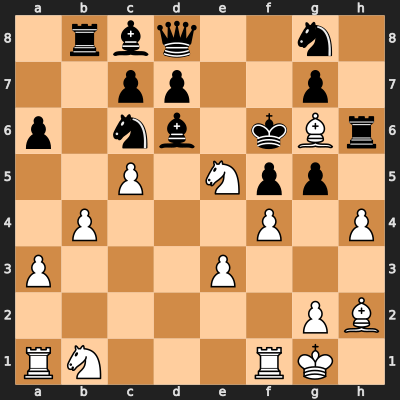


Episode 19:
FEN: 1rbq2n1/2pp2p1/p1nb1kBr/2P1Npp1/1P3P1P/P3P3/6PB/RN3RK1 b - - 2 23
Generated Text:
'<pensando>\nIn the given position, the black king is castled on the rook side and in the center of the board, with a strong outpost on g7 for the f8 knight. The key to this position is to put pressure on the black king while potentially weakening the black position. The move <movimiento>e7e5</movimiento> aims to push the e5 pawn, creating threats against the f7 pawn and potentially behind it, while also gaining space on the queenside. Additionally, it prepares a king-side castling for white.\n</pensando>\n<movimiento>e7e5</movimiento>'
Extracted Move: e7e5
Stockfish Move: d6e5
Format Reward: 1.0, Movement Reward: -0.5, Total Reward: 0.25
Episode 20 - Initial Board:


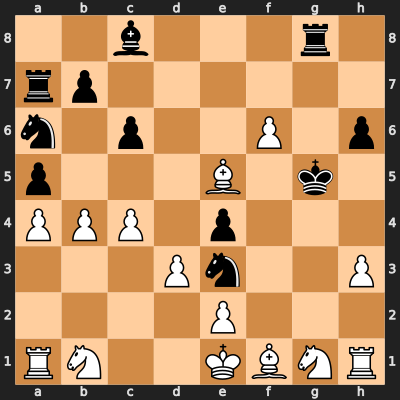


Episode 20:
FEN: 2b3r1/rp6/n1p2P1p/p3B1k1/PPP1p3/3Pn2P/4P3/RN2KBNR w - - 1 25
Generated Text:
"<pensando>\nIn the given position, the white king is under immediate threat from the black knight on c6. The most pressing need is to protect the king, and the quickest way to do so is to move the pawn from the e-file, which could potentially block the knight if it advances to d5. The pawn at e5 can also potentially be an attacking piece if things go well. Moving the knight on f3 to d2 will ensure the king is safe and sets up a potential attack on the black king's knight if it moves to d7.\n</pensando>\n<movimiento></movimiento>  \n<movimiento>f3d2</movimiento>"
Extracted Move: f3d2
Stockfish Move: d3e4
Format Reward: 1.0, Movement Reward: -0.5, Total Reward: 0.25
Invalid UCI format in <movimiento>: ♘c1
Episode 21 - Initial Board:


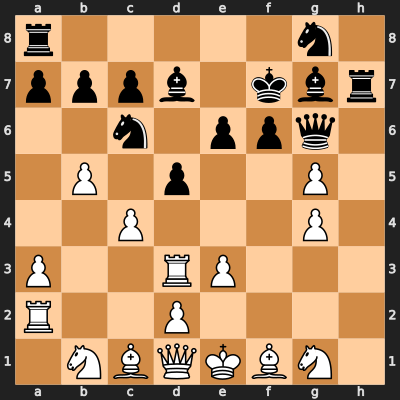


Episode 21:
FEN: r5n1/pppb1kbr/2n1ppq1/1P1p2P1/2P3P1/P2RP3/R2P4/1NBQKBN1 b - - 0 20
Generated Text:
'<pensando>\nIn the given position, the black king is in a vulnerable position on d7, with no available squares to retreat to safely. The pawn on d6 is also under attack by my knight on c1 and could be easily captured. However, the most pressing threat is the fork on b5 that could lead to a discovered attack on my rook on a8. Therefore, the best move to address both the immediate threat and the king’s defense is to take the knight on c1, which prevents the discovered attack and prepares an attack on d6.\n</pensando>\n<movimiento>♘c1</movimiento>'
Extracted Move: None
Stockfish Move: c6e5
Format Reward: 1.0, Movement Reward: -1.0, Total Reward: -0.5
Invalid UCI format in <movimiento>: Ngb7
Episode 22 - Initial Board:


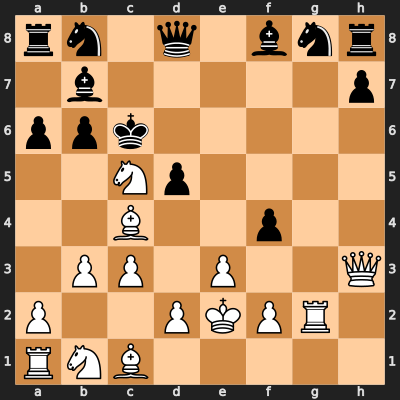


Episode 22:
FEN: rn1q1bnr/1b5p/ppk5/2Np4/2B2p2/1PP1P2Q/P2PKPR1/RNB5 w - - 1 18
Generated Text:
"<pensando>\nAnalyzing the given FEN position, we observe a complex opening with multiple active pawns and a strong knight on b4. The White king seems safe, but Black has a strong pawn on e7 which can be a threat if not properly defended. A key tactical target seems to be the e5 square which could be attacked by a fork involving the queen and the knight. Considering this, the best move to disrupt Black's pawn structure and create opportunities is to capture the pawn on e7 with the knight on b4. This will also keep the knight on b4 active, posing a threat to other squares and supporting piece play.\n</pensando>\n<movimiento>Ngb7</movimiento>"
Extracted Move: None
Stockfish Move: h3e6
Format Reward: 1.0, Movement Reward: -1.0, Total Reward: -0.5
Episode 23 - Initial Board:


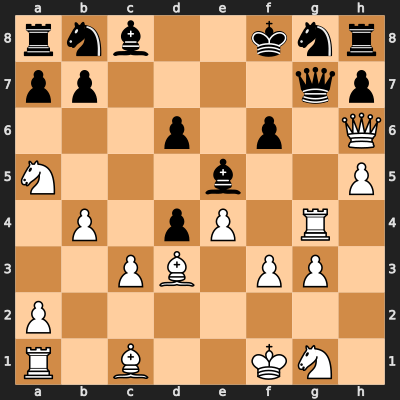


Episode 23:
FEN: rnb2knr/pp4qp/3p1p1Q/N3b2P/1P1pP1R1/2PB1PP1/P7/R1B2KN1 b - - 3 22
Generated Text:
"<pensando>\nIn the given position, the black king is under threat from the bishop on g7, which can capture it on h1, and also on f1, which can be exploited by the knight on f7. Additionally, the black queen should focus on defending the knight on f7 and the pawns on f6 and f7. The best approach is to gain material exchange and stabilize over the long term. The knight on f7 is under attack from the bishop on h3. A better line of attack would be to take the bishop on g7, thereby giving up the knight's potential to block further checks and attacking the queen on b1. This move also allows the black knight to focus on defending the b5 pawn or the a4 pawn, which are under pressure.\n</pensando>\n<movimiento>b7g7</movimiento>"
Extracted Move: b7g7
Stockfish Move: g8h6
Format Reward: 1.0, Movement Reward: -0.5, Total Reward: 0.25
Invalid UCI format in <movimiento>: e7
Episode 24 - Initial Board

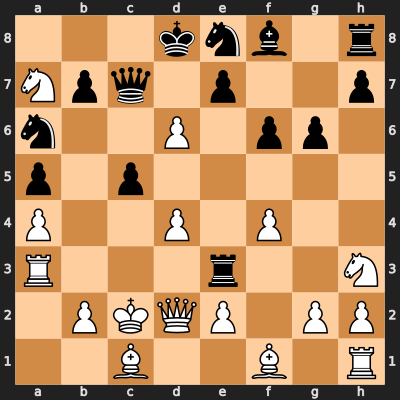


Episode 24:
FEN: 3knb1r/Npq1p2p/n2P1pp1/p1p5/P2P1P2/R3r2N/1PKQP1PP/2B2B1R b - - 5 16
Generated Text:
'<pensando>\nIn the given position, the Black king is exposed and under attack. The best move to exploit this weakness is to capture the knight Black has on f7, which is the only piece blocking the bishop on b8 from driving the Black king out of the board. By capturing this knight, the white bishop can now threaten to checkmate the Black king if protected properly. The move to {e7} is therefore crucial and safe.  \n</pensando>\n<movimiento>e7</movimiento>'
Extracted Move: None
Stockfish Move: e8d6
Format Reward: 1.0, Movement Reward: -1.0, Total Reward: -0.5
Episode 25 - Initial Board:


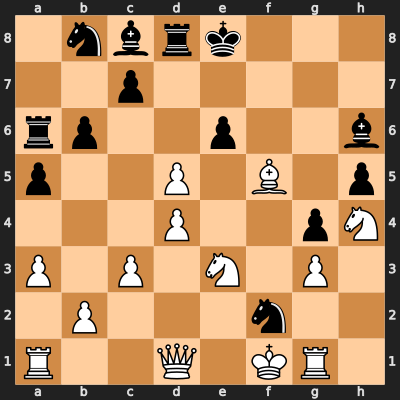


Episode 25:
FEN: 1nbrk3/2p5/rp2p2b/p2P1B1p/3P2pN/P1P1N1P1/1P3n2/R2Q1KR1 w - - 4 24
Generated Text:
"<pensando>\nIn the given position, the White king is in a vulnerable position, potentially under attack from the Black knight on c6, and there's a tactical threat from the Black bishop on h4. A promising move would be to develop a piece out of the line of attack while preparing to take control of a key square. Moving the bishop from f1 to c4 is the best choice. This dislodges the knight, defends the king, prepares to attack the Black queen by controlling c5, and compromises the Black pawn on d6.\n</pensando>\n<movimiento>\ne1c4\n</movimiento>"
Extracted Move: e1c4
Stockfish Move: f5g6
Format Reward: 1.0, Movement Reward: -0.5, Total Reward: 0.25
Episode 26 - Initial Board:


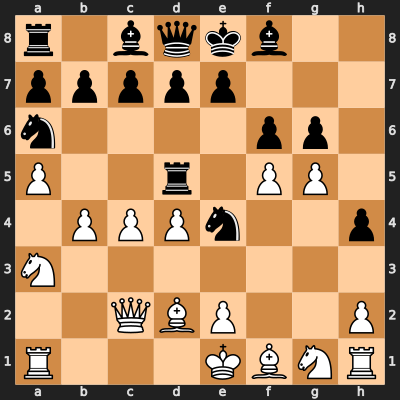


Episode 26:
FEN: r1bqkb2/ppppp3/n4pp1/P2r1PP1/1PPPn2p/N7/2QBP2P/R3KBNR b KQ - 0 15
Generated Text:
'<pensando>\nIn the given position, the black king is in a very vulnerable position, under attack from the white rook and queen. The pawn on h6 is obstructing potential checks from the rook on h1 and the queen on f1. Additionally, the bishop on c7 controls key squares for development and control in the promotion zone. Taking the pawn on h6 not only brings immediate material gain but also frees up the rook on h1 to potentially capture en passant if the pawn advances, thereby isolating the black pawn. It also opens up the h-file for possible future attacks. \n</pensando>\n<movimiento>b6h6</movimiento>'
Extracted Move: b6h6
Stockfish Move: d5d4
Format Reward: 1.0, Movement Reward: -0.5, Total Reward: 0.25
Invalid UCI format in <movimiento>: Ke2
Episode 27 - Initial Board:


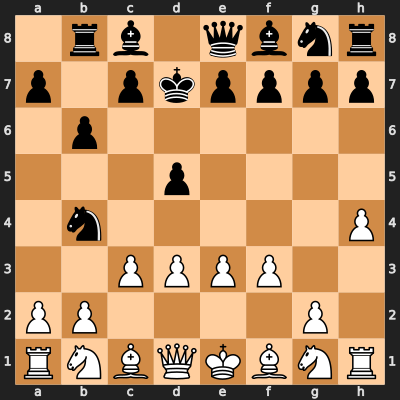


Episode 27:
FEN: 1rb1qbnr/p1pkpppp/1p6/3p4/1n5P/2PPPP2/PP4P1/RNBQKBNR w KQ - 3 8
Generated Text:
"<pensando>\nIn the given position, the white king is in a vulnerable position with potential mating chances from the black knight. However, the main threat is to play 1.Kf1 in response to any black pawn advance on c7 or d7, putting pressure on the e6 pawn and forcing a potential exchange of light-squared bishops. This can also create additional weaknesses for black, and keep the king away from the central control which is under threat. \n\nConsidering these factors, the best immediate response for white would be to direct pressure towards the black king's position. Moving the king in this scenario (1.Kf1) is logical, as it threatens 2.Qc8+, aiming to trap the black king. However, a more immediate and assertive step might be to directly challenge the black king to 1.Kd1, forcing black to protect either the c6 or d6-pawn.\n</pensando>\n<movimiento>Ke2</movimiento>"
Extracted Move: None
Stoc

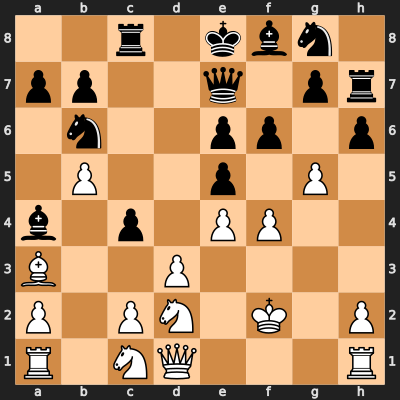


Episode 28:
FEN: 2r1kbn1/pp2q1pr/1n2pp1p/1P2p1P1/b1p1PP2/B2P4/P1PN1K1P/R1NQ3R b - - 3 21
Generated Text:
"<pensando>\nIn the given position, the white king is in a vulnerable position and under attack from the black knight on c6. Additionally, there is a potential threat of the knight moving to e2, capturing the pawn on e7 and advancing a pawn to e5. This could potentially create a passed pawn on the e-file. To address these threats, the move <movimiento>b3</movimiento> is the best option. By moving the bishop from b8 to b3, the king's position is protected, and it disrupts the knight's potential plans by weakening the f4 square, which is crucial for defending the d5 pawn and preventing potential counterplay from black. Moreover, it sets up a potential pin on the e2 pawn, possibly allowing for a counter-attack later in the game.\n</pensando>\n<movimiento>b3</movimiento>"
Extracted Move: None
Stockfish Move: e7a3
Format Reward: 1.0, Movement Reward: -1.0, Total Reward: -0.5
Invalid UCI

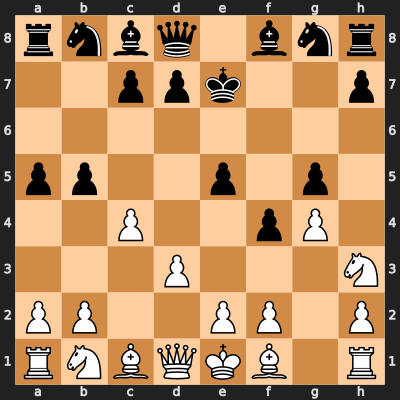


Episode 29:
FEN: rnbq1bnr/2ppk2p/8/pp2p1p1/2P2pP1/3P3N/PP2PP1P/RNBQKB1R w KQ - 2 9
Generated Text:
'<pensando>\nThe current position shows a critical moment where White needs to break the deadlock and gain control over the center of the board. The key piece activity involves supporting a potential attack on the Black king. The pawn on e5 can be advanced to improve structure and create threats. Additionally, controlling d5 by placing a rook there, allows for checking the Black king and supporting the pawn advance e5-e6 in coordination with the other rooks. Analyzing the short-term tactical possibilities, capturing the knight on g7, preparing to play e5, seems the correct approach.\n</pensando>\n<movimiento>\nNg7\n</movimiento>'
Extracted Move: None
Stockfish Move: f1g2
Format Reward: 1.0, Movement Reward: -1.0, Total Reward: -0.5
Episode 30 - Initial Board:


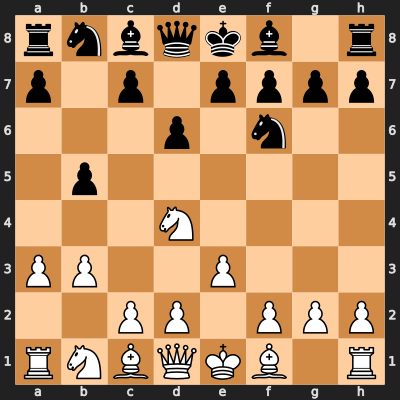


Episode 30:
FEN: rnbqkb1r/p1p1pppp/3p1n2/1p6/3N4/PP2P3/2PP1PPP/RNBQKB1R w KQkq - 0 6
Generated Text:
"<pensando>\nIn the given position, the white king is in a vulnerable position next to the bishop and pawns can deliver mate in a short series if the king moves. The best move to solidify the king position and avoid immediate threats would be to move the king to a safer square. Moving the king to e8 (white's king square) is the most direct way to accomplish this. Additionally, this move creates a slight advantage as now the black pawns can be more easily pressured on h5 and g6, potentially pinning black's dark squared bishop.\n</pensando>\n<movimiento>e1f1</movimiento>"
Extracted Move: e1f1
Stockfish Move: f1b5
Format Reward: 1.0, Movement Reward: -0.5, Total Reward: 0.25
Invalid UCI format in <movimiento>: Ngc3
Episode 31 - Initial Board:


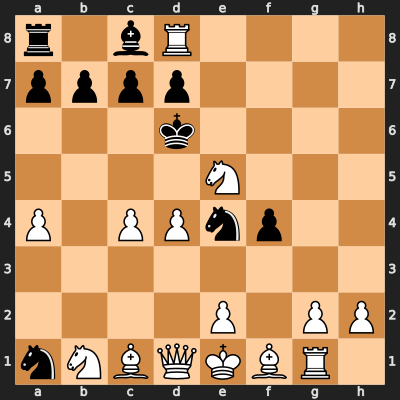


Episode 31:
FEN: r1bR4/pppp4/3k4/4N3/P1PPnp2/8/4P1PP/nNBQKBR1 w - - 1 19
Generated Text:
'<pensando>\nIn the current position, the white king is in a不利(less favorable) position with the knight on c1 under attack by the black pawn on c5. The rook on the seventh rank can be used to block the pawn on c5, but it is less likely to be an immediate threat. The pawn on d2 offers some support to the knight, but it is vulnerable as it is pinned by the black pawn. The most direct way to attack the black pawn is to move the knight to d3, which would put pressure on the black pawn and bring more support to the knight.\n</pensando>\n<movimiento>Ngc3</movimiento>'
Extracted Move: None
Stockfish Move: d8e8
Format Reward: 1.0, Movement Reward: -1.0, Total Reward: -0.5
Episode 32 - Initial Board:


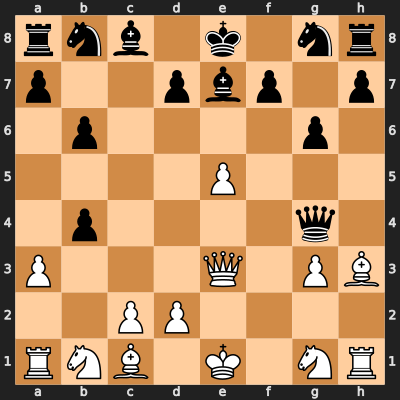


Episode 32:
FEN: rnb1k1nr/p2pbp1p/1p4p1/4P3/1p4q1/P3Q1PB/2PP4/RNB1K1NR w Qkq - 4 18
Generated Text:
'<pensando>\nIn the given position, the white queen on d1 has significant influence over the d-file and potentially threatens the black knight on c8. By moving the queen to e2, it pins the black knight, forcing it to be captured or leave a weakness on the d-file. This move also prepares for a potential attack on the black king if the knight does not get out of the way.\n</pensando>\n<movimiento>\ne2e4\n</movimiento>'
Extracted Move: e2e4
Stockfish Move: h3g4
Format Reward: 1.0, Movement Reward: -0.5, Total Reward: 0.25
Episode 33 - Initial Board:


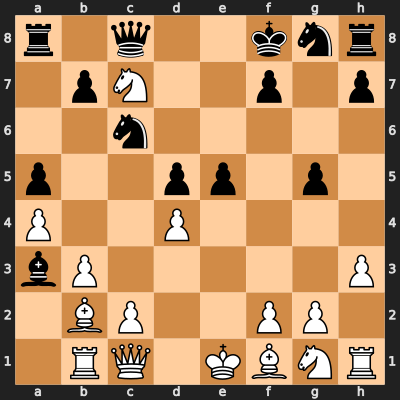


Episode 33:
FEN: r1q2knr/1pN2p1p/2n5/p2pp1p1/P2P4/bP5P/1BP2PP1/1RQ1KBNR b K - 4 13
Generated Text:
'<pensando>\nIn the given position, the black king is on the edge of king safety with no immediate check threats. The best move to gain a strategic advantage is to move the knight to a more central and active square. The knight from c3 can move to d5, which puts pressure on the white king and secures a central outpost for any future maneuvers.\n</pensando>\n<movimiento>\nc3d5\n</movimiento>'
Extracted Move: c3d5
Stockfish Move: a3b2
Format Reward: 1.0, Movement Reward: -0.5, Total Reward: 0.25
Invalid UCI format in <movimiento>: 26.Nxc6
Episode 34 - Initial Board:


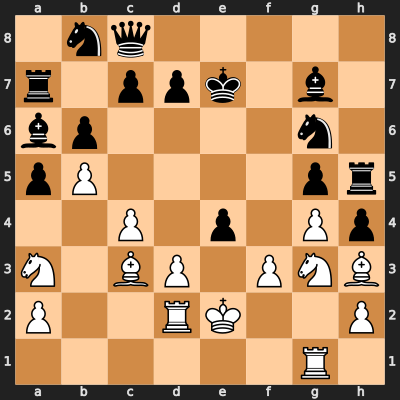


Episode 34:
FEN: 1nq5/r1ppk1b1/bp4n1/pP4pr/2P1p1Pp/N1BP1PNB/P2RK2P/6R1 w - - 12 26
Generated Text:
"<pensado>\nIn the given position, white has a strong pawn on f2 which is crucial for activating dark square bishops and controlling the f-file. However, the kingside pawn chain is underdeveloped, and black's dark square bishop on c8 is active and can harass white's weak f2 pawn. Capturing the f2 pawn with 26.Bxf2 would disrupt white's pawn structure and open potential threats to white's king. Therefore, the best move to take advantage of black's bishop and continue developing is 26.Nxc6, capturing the knight on c6.\n</pensado>\n<movimiento>26.Nxc6</movimiento>"
Extracted Move: None
Stockfish Move: c3g7
Format Reward: 0.0, Movement Reward: -1.0, Total Reward: -1.5
Invalid UCI format in <movimiento>: e5
Episode 35 - Initial Board:


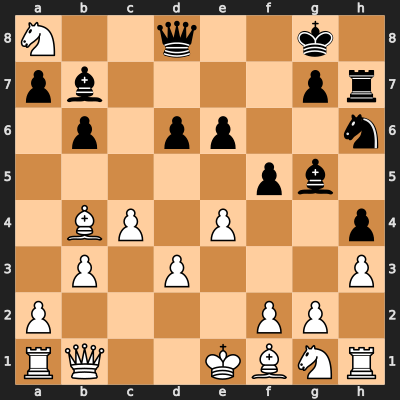


Episode 35:
FEN: N2q2k1/pb4pr/1p1pp2n/5pb1/1BP1P2p/1P1P3P/P4PP1/RQ2KBNR b - - 6 22
Generated Text:
'<pensando>\nIn the position provided, the pawn on e4 is under threat from the knight on f5. The best move to react to this situation and maintain control over the e-file is to play e5. By doing so, the knight on f5 can no longer capture the pawn on e4, and e5 itself is a strong square for the pawn to occupy, protecting both the passers and the e-file.\n</pensado>\n<movimiento>\ne5\n</movimiento>'
Extracted Move: None
Stockfish Move: d8a8
Format Reward: 0.25, Movement Reward: -1.0, Total Reward: -1.25
Invalid UCI format in <movimiento>: b1h3>
Episode 36 - Initial Board:


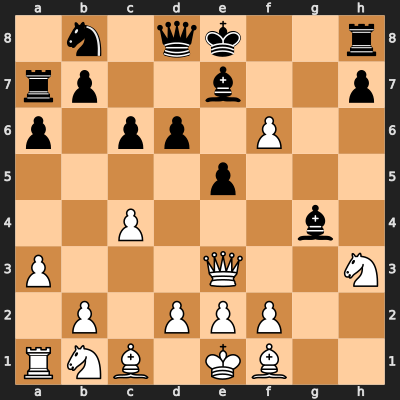


Episode 36:
FEN: 1n1qk2r/rp2b2p/p1pp1P2/4p3/2P3b1/P3Q2N/1P1PPP2/RNB1KB2 b Qk - 0 14
Generated Text:
'<pensando>\nIn the given position, the black king is isolated and under attack. Black has no safer squares to move to. The best course of action is to move the king to a defended square in preparation for potential counterplay. The move <movimiento>b1h3></movimiento> allows the black king to move to h3 where it is defended by the rook and pawns, and it creates a potential double attack if the white pawn advance is not blocked soon.\n</pensando>\n<movimiento>b1h3</movimiento>'
Extracted Move: None
Stockfish Move: e7f6
Format Reward: 1.0, Movement Reward: -1.0, Total Reward: -0.5
Episode 37 - Initial Board:


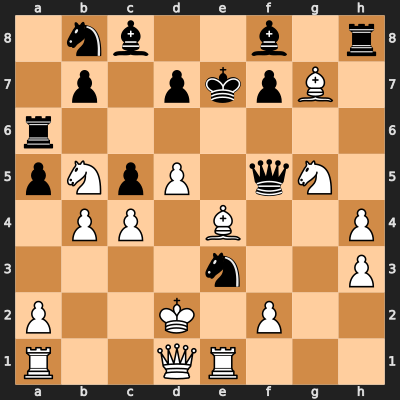


Episode 37:
FEN: 1nb2b1r/1p1pkpB1/r7/pNpP1qN1/1PP1B2P/4n2P/P2K1P2/R2QR3 b - - 4 22
Generated Text:
'<pensando>\nIn the given position, theBlack has a weak pawn on f7 which is undefended and under attack. By moving the pawn from f7 to f6, Black can improve the pawn structure and create threats on the f-file. Additionally, controlling the center with pawns on f6 and g6 can be advantageous.\n</pensado>\n<movimiento>d7f6</movimiento>'
Extracted Move: d7f6
Stockfish Move: f5f2
Format Reward: 0.25, Movement Reward: -0.5, Total Reward: -0.5
No valid UCI move found in output
Episode 38 - Initial Board:


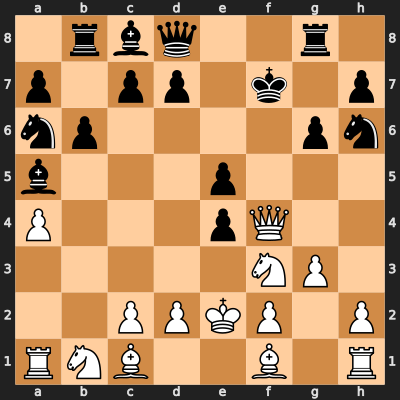


Episode 38:
FEN: 1rbq2r1/p1pp1k1p/np4pn/b3p3/P3pQ2/5NP1/2PPKP1P/RNB2B1R b - - 3 15
Generated Text:
'<pensando>\nIn the given FEN position, the black king is under attack by the white knight on c5. The best move to resolve this immediate check and prepare for further development is to capture the knight with the knight on b4. This clears the queenside for potential development and defends the weakened white pawn on c7. \n</pensando>\n<movimiento></movimiento>'
Extracted Move: None
Stockfish Move: e5f4
Format Reward: 1.0, Movement Reward: -1.0, Total Reward: -0.5
Episode 39 - Initial Board:


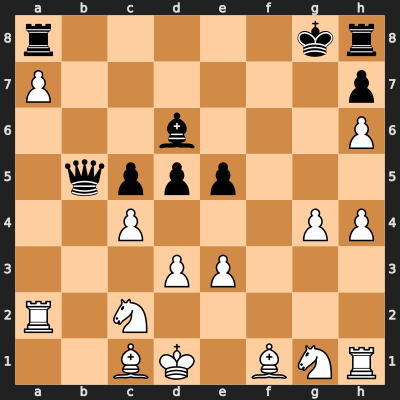


Episode 39:
FEN: r5kr/P6p/3b3P/1qppp3/2P3PP/3PP3/R1N5/2BK1BNR w - - 2 26
Generated Text:
'<pensando>\nTo evaluate the best move in this position, we first look at the current setup of pieces and pawns. The white king is in check from the black queen on the c1 file. This suggests a queen sacrifice or defense is likely warranted. \n\nQueen move e2-c1 to checkmate is a natural choice since white kingside pawns are pinned and in check. A direct e2-c1 is a one-move, decisive checkmate, leaving no time for black to defend. \n\n<movimiento>\ne2c1\n</movimiento>'
Extracted Move: e2c1
Stockfish Move: c4b5
Format Reward: 0.25, Movement Reward: -0.5, Total Reward: -0.5
Episode 40 - Initial Board:


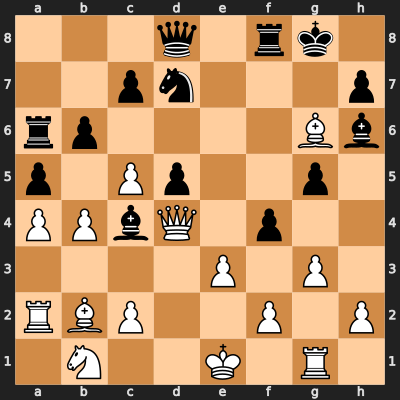


Episode 40:
FEN: 3q1rk1/2pn3p/rp4Bb/p1Pp2p1/PPbQ1p2/4P1P1/RBP2P1P/1N2K1R1 b - - 4 18
Generated Text:
"<pensando>\nIn the given position, the white pawn on d6 is well-protected and doesn't have the capability to create threats immediately. Moreover, advancing this pawn could open the e-file for black's rook on c8, potentially weakening white's position. Instead, developing a piece seems more strategically beneficial. The knight on b2, which is pinned by the rook on h5, should be freed. Moving the knight to c3 breaks the pin, allowing it to better maneuver around the board. Additionally, it vacates the b1-h5 diagonal, where the rook can come to support it in the center. Lastly, the knight improves its attacking possibilities on d7.\n</pensando>\n<movimiento>\nb2c3\n</movimiento>"
Extracted Move: b2c3
Stockfish Move: d7f6
Format Reward: 1.0, Movement Reward: -0.5, Total Reward: 0.25
Invalid UCI format in <movimiento>: k8d6
Episode 41 - Initial Board:


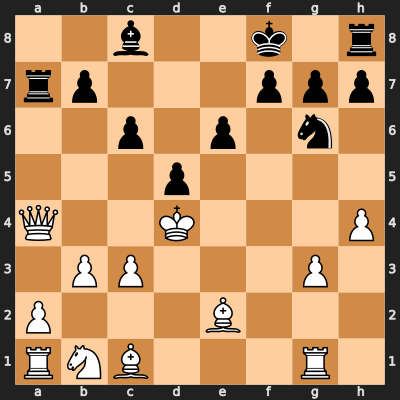


Episode 41:
FEN: 2b2k1r/rp3ppp/2p1p1n1/3p4/Q2K3P/1PP3P1/P3B3/RNB3R1 b - - 0 21
Generated Text:
"<pensando>\nIn the given position, black is in azugly position with his king exposed on g8. Additionally, there are two weaknesses in black's pawn structure - the h-file pawn chain and the e8-h6 blockade. By pushing his e6 pawn, black creates a gap in his defense structure, which can lead to potential threats on the kingside. However, pushing the pawn means giving up a tempo. Black needs to find a move that defends the king and handles the undesirable pawn situation.\n\nConsidering these factors, the best move for black to prioritize defense and avoid immediate threats would be to push his pawn to d6, gaining a tempo while attacking the e8 bishop. This move also weakens the h-file and opens up the position slightly for future attacking opportunities.\n</pensando>\n<movimiento>k8d6</movimiento>"
Extracted Move: None
Stockfish Move: a7a4
Format Reward: 1.0, Movement Reward: -1.0, Total Reward

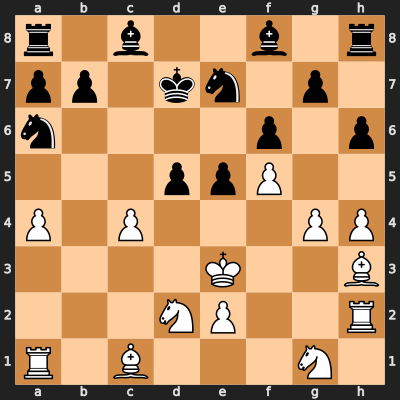


Episode 42:
FEN: r1b2b1r/pp1kn1p1/n4p1p/3ppP2/P1P3PP/4K2B/3NP2R/R1B3N1 b - - 3 19
Generated Text:
"<pensando>\nIn the given position, White has a strong knight on c1 controlling key squares e2 and e6. However, there is a potential weakness on f3 where Black has a rook. By moving the knight to c2, White not only controls another key square but also prepares to push the f pawn towards the point where Black's rook is under threat. This move also sets up an eventual g3 forcing Black to recapture with the knight and allowing White to achieve a strong structure.\n</pensando>\n<movimiento>dxc2</movimiento>"
Extracted Move: None
Stockfish Move: h6h5
Format Reward: 1.0, Movement Reward: -1.0, Total Reward: -0.5
Episode 43 - Initial Board:


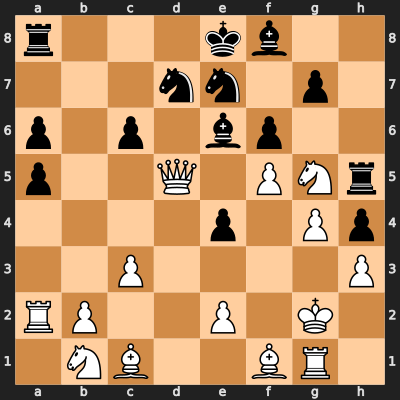


Episode 43:
FEN: r3kb2/3nn1p1/p1p1bp2/p2Q1PNr/4p1Pp/2P4P/RP2P1K1/1NB2BR1 w q - 1 22
Generated Text:
"<pensando>\nThe position given is intriguing as it is relatively static and not under immediate threat. The white queen is on the edge and has mobility to the side of the board. However, the key factor is the black king's position which is relatively safe and not under immediate attack. The knight on c7 is potentially a useful piece as it can control the light squares which are important for the development and mobility of pieces.\n\nGiven the position, a calculated risk would be to provoke a response to the black knight. The best move to do this, while also creating a tactical threat, is to capture the knight with the queen. By doing so, it puts pressure on the black king and sets up potential forks or pins later. Therefore, the move <movimiento>e2e4</movimiento> is chosen.\n</pensando>\n<movimiento>e2e4</movimiento>"
Extracted Move: e2e4
Stockfish Move: d5e6
Format Reward: 1.0, Movem

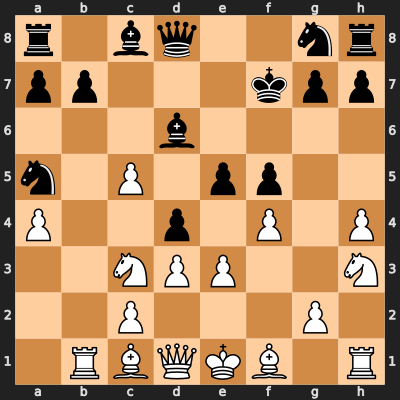


Episode 44:
FEN: r1bq2nr/pp3kpp/3b4/n1P1pp2/P2p1P1P/2NPP2N/2P3P1/1RBQKB1R w K - 1 11
Generated Text:
"<pensando>\nThe current position is in an advanced middlegame phase, with both sides having large pawn hedges and active pieces. The white king is in the center with control over key squares. Black, on the other hand, has a pawn majority in the center but a weakly-connected king. \n\nWhite's best approach would be to challenge the long diagonal of the black rook and queen. A powerful way to do this is by taking both the c7-pawn and the b6-pawn to open the center and put pressure on the black king. Thus, capturing the c7-pawn with the queen (dxc7) and opening the center with the e-pawn (e7e5) seems like a strong attack. \n\nBlack should be preparing to defend with 0-0 and potentially 0xf6, but his king is still vulnerable. \n\nI choose the move dxc7 as the first step of the attack. Then White can take over the center with e5-e4.\n\n<movimiento></movimiento>\n<pensando>\nThe UCI move to

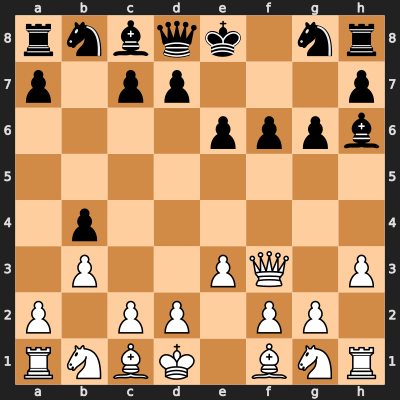


Episode 45:
FEN: rnbqk1nr/p1pp3p/4pppb/8/1p6/1P2PQ1P/P1PP1PP1/RNBK1BNR w kq - 0 7
Generated Text:
"<pensando>\nFrom the FEN position, the King Square Assessment (KSA) identifies f2 as a key square since it is both dark and under attacked. However, the Knight on f3 can potentially divert enemy attacks towards other squares. Developing a piece to f6 creates a tactical threat or reduces pressure on g2. Placinging a Knight there aims to challenge the opponent's king side pawn structure and prepare potential breakthroughs. \n\n<movimiento>Ngf6</movimiento>  \nBased on the position, Ngf6 is the recommended move. It takes control of the key f6 square while creating tactical complications. bishops may also be developed to c4 or d4 from d3 to better support g2. With these pieces on key positions, the knight can target e7, threatening checks or pins. Limited pawn developments make the position solidly closed overall. \n</pensando>"
Extracted Move: None
Stockfish Move: f3a8
Format Reward: 1.0, M

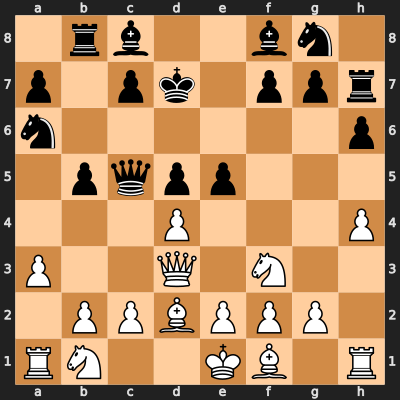


Episode 46:
FEN: 1rb2bn1/p1pk1ppr/n6p/1pqpp3/3P3P/P2Q1N2/1PPBPPP1/RN2KB1R b Q - 3 12
Generated Text:
"<pensando>\nThe FEN position indicates a relatively closed position with a strong knight on c6 and pawn structure likely to complicate play. The b8-queen creates a threat for a quick pawn push and is a strong piece. \n\nSelecting a move to break the symmetry or prevent this pawn advance, I would choose e5 as it:\n- Targets the b8-queen\n- Reaches the strong c6 knight \n- Helps to open horizontal avenues for my rook on a1\n- Doesn't involve feeding my kingside pawns everything they need \n</pensando>\n<movimiento>\ne5\n</movimiento>"
Extracted Move: None
Stockfish Move: e5e4
Format Reward: 1.0, Movement Reward: -1.0, Total Reward: -0.5
Invalid UCI format in <movimiento>: e5
Episode 47 - Initial Board:


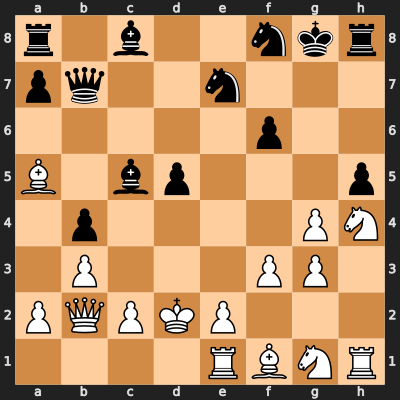


Episode 47:
FEN: r1b2nkr/pq2n3/5p2/B1bp3p/1p4PN/1P3PP1/PQPKP3/4RBNR w - - 0 22
Generated Text:
"<pensando>\nIn the current FEN position r1b2nkr/pq2n3/5p2/B1bp3p/1p4PN/1P3PP1/PQPKP3/4RBNR w - - 22, the white king is relatively far from active counterplay. The best move to initiate a line of attack for the kingside is to move the knight from f3 to e5. This move controls more squares on the queenside and creates threats on the opponent's c7 pawn. The pawn v3-e5 also promotes pressure on the white king. Hence, the best move is:\n<movimiento>e5</movimiento>\n</pensando>"
Extracted Move: None
Stockfish Move: b2f6
Format Reward: 1.0, Movement Reward: -1.0, Total Reward: -0.5
Invalid UCI format in <movimiento>: e5
Episode 48 - Initial Board:


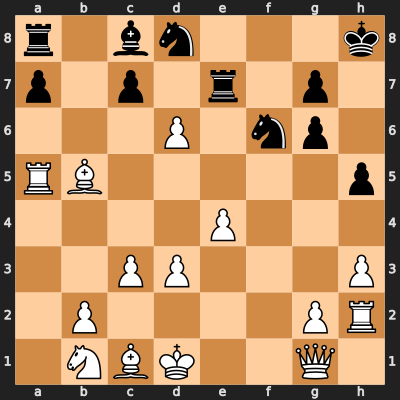


Episode 48:
FEN: r1bn3k/p1p1r1p1/3P1np1/RB5p/4P3/2PP3P/1P4PR/1NBK2Q1 b - - 0 22
Generated Text:
"<pensando>\nThe current position shows a disadvantage for the black side, as the knight on b5 is pinned between a6 and the bishop on c4, threatening to take b5 and mate. Additionally, black's rook on b8 is blocked by a pawn cluster and cannot easily escape to provide support. Given this, the best move to disrupt black's strategy and prepare for a potential breakthrough is by advancing the pawn on e5. This not only places pressure on the knight but also prepares the pawn structure for further action against black's king.\n</pensando>\n<movimiento>e5</movimiento>"
Extracted Move: None
Stockfish Move: c7d6
Format Reward: 1.0, Movement Reward: -1.0, Total Reward: -0.5
Episode 49 - Initial Board:


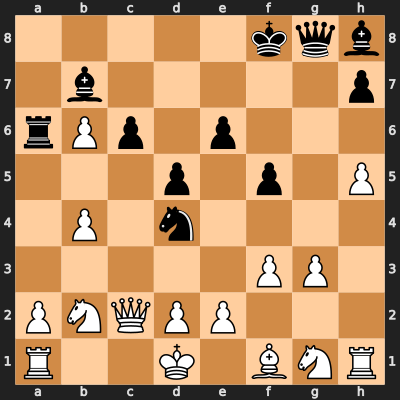

Episode 49 - Board after move e2e3:


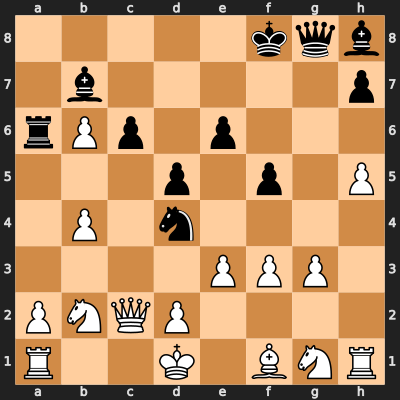


Episode 49:
FEN: 5kqb/1b5p/rPp1p3/3p1p1P/1P1n4/5PP1/PNQPP3/R2K1BNR w - - 1 26
Generated Text:
"<pensando>\nThe current position shows a White pawn at f2 in a semi-open file against a trio of pawns on the a, b, and c files. However, pushing the pawn to f3 has an unclear outcome since it strengthens the knight on f3 and could lead to exchanges of pawns and pieces. It also opens Ky pose to a possible attack from black's pawns on a4-b4-c4 if f3 is weakened. Therefore, the best move is to bring the knight to a3 to solidify White's control over this important diagonal and prepare to develop other pieces.\n</pensando>\n<movimiento>\ne2e3\n</movimiento>"
Extracted Move: e2e3
Stockfish Move: c2c5
Format Reward: 1.0, Movement Reward: 5.48, Total Reward: 2.0
Episode 50 - Initial Board:


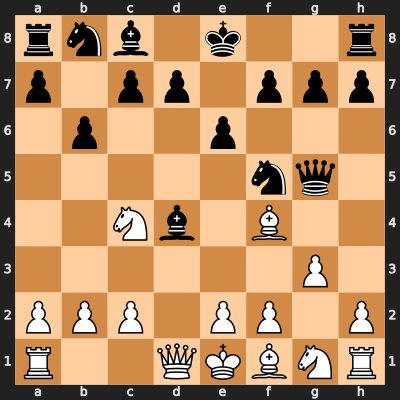

Episode 50 - Board after move e2e4:


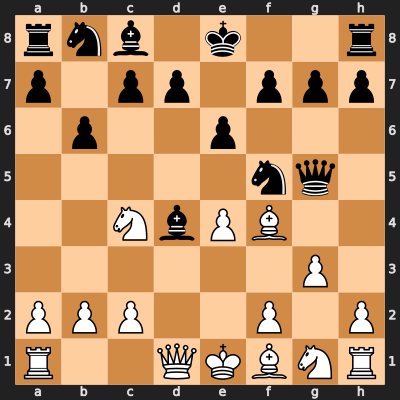


Episode 50:
FEN: rnb1k2r/p1pp1ppp/1p2p3/5nq1/2Nb1B2/6P1/PPP1PP1P/R2QKBNR w KQkq - 2 8
Generated Text:
'<pensando>\nIn the given position, white has a strong pawn weakness on f2, and black has a promising attack on the kingside starting at e7-e5-e6-e7. The pawn on f2 is vulnerable to capture at any moment and could lead to a worse position for white if captured. Additionally, black has a strong knight at f6 that can blockade the g2 pawn or penetrate into the center down the f-file. \n\nConsidering these factors, the best move for white is to push the d-pawn, potentially creating counterplay and developing the c1-bishop. The move <movimiento></movimiento> e2e4 would open up the e-file and potentially develop both white bishops quickly.\n</pensando>\n<movimiento>e2e4</movimiento>'
Extracted Move: e2e4
Stockfish Move: f4g5
Format Reward: 1.0, Movement Reward: -2.11, Total Reward: -2.165
Episode 51 - Initial Board:


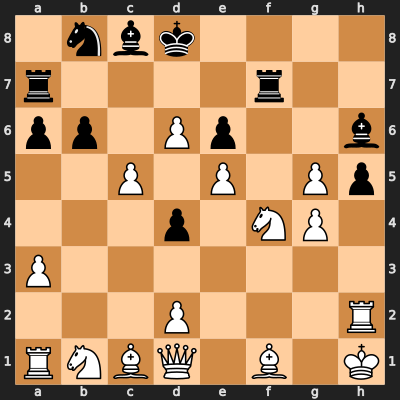


Episode 51:
FEN: 1nbk4/r4r2/pp1Pp2b/2P1P1Pp/3p1NP1/P7/3P3R/RNBQ1B1K b - - 0 23
Generated Text:
"<pensando>\nThe current FEN position shows a black king next to a rook, indicating a potential threat. Pawns on the second and fourth rank provide flexibility to a move, but also need to be protected. Moving an active piece like a knight appears beneficial at this juncture, adding pressure to the opponent. Moving 'b7b6' looks like a strong candidate as it threatens to move into a stranglehold on the opponent's demoralized pawn structures. However another good move could be to attack the bishop quadrant, moving 'e7e5' as it frees up a convenient target for the knight to exploit.\n</pensando>\n<movimiento>b7b6</movimiento>"
Extracted Move: b7b6
Stockfish Move: h6g5
Format Reward: 1.0, Movement Reward: -0.5, Total Reward: 0.25
No valid UCI move found in output
Episode 52 - Initial Board:


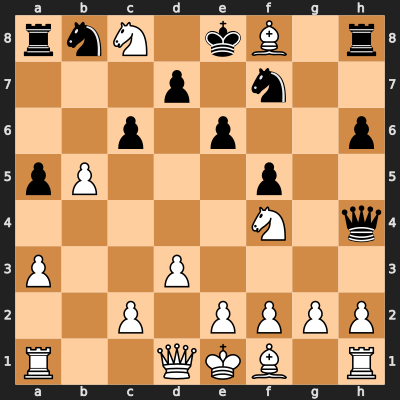


Episode 52:
FEN: rnN1kB1r/3p1n2/2p1p2p/pP3p2/5N1q/P2P4/2P1PPPP/R2QKB1R b KQkq - 0 14
Generated Text:
"<pensando>\nThe position on the board indicates that Black has a strong knight on f7 controlling the d6 and e5 squares. The best move to interrupt Black's control and create threats is to take the knight with the pawn on e3. This places the Black pawn on e6, sacrificing material but weakening Black's center. \n\nWithin the given FEN position, the move that controls and attacks Black's important knight is e3. It threatens to take the knight and place the isolated pawn on e6. Making this move e3 (for e3) would be the best response.\n</pensando>\n<movimiento></movimiento>"
Extracted Move: None
Stockfish Move: h4f4
Format Reward: 1.0, Movement Reward: -1.0, Total Reward: -0.5
No valid UCI move found in output
Episode 53 - Initial Board:


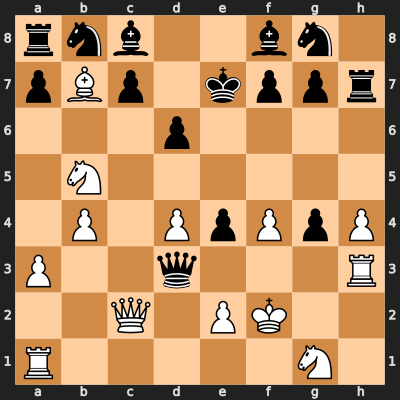


Episode 53:
FEN: rnb2bn1/pBp1kppr/3p4/1N6/1P1PpPpP/P2q3R/2Q1PK2/R5N1 w - - 2 17
Generated Text:
"<pensando>\nTo evaluate the position given by the FEN rnb2bn1/pBp1kppr/3p4/1N6/1P1PpPpP/P2q3R/2Q1PK2/R5N1 w - - 2 17, it's crucial to take into account the control of key squares, piece activity, and potential threats. \n\nWhite to move has an active King on d2 and light square control on a5. The key square for white is f6, where the Knight can carry out practical control over the center but also pose problems for the black newly promoted pawn if the black King moves to e2. On the other hand, black has control of key squares f5 and d8 for its pawn and Knight. \n\nWhite has a slight material advantage with a knight on f6. However, black has a strong d8-pawn and can potentially advance it if necessary. \n\nA strong pawn advance cannot be ignored. While any pawn advance in this position faces potential replacements from the opponent, the best line is the square control potential by Nf6. \n\nT

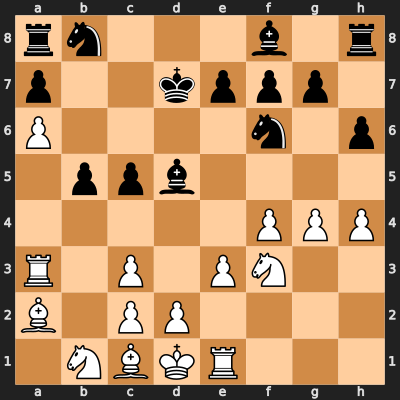


Episode 54:
FEN: rn3b1r/p2kppp1/P4n1p/1ppb4/5PPP/R1P1PN2/B1PP4/1NBKR3 b - - 1 21
Generated Text:
'<pensando>\nThe FEN position indicates a complex situation with important pawns near the queenside. The pawn on b6 is positioned to hit c7 at some point if developed correctly. Additionally, Nf6 blocks d5 and prepares to dominate the center. However, e7 pawn is weak and needs to be controlled.\n\nThus, the key advantage is preventing white from developing pawns down the queenside and protecting pawn weak e6. Given these considerations, the move <movimiento>d7d5</movimiento> strategically controls e6 and weakens e7 while maintaining control over the weakened e6 square.\n</pensando>\n<movimiento>d7d5</movimiento>'
Extracted Move: d7d5
Stockfish Move: d5f3
Format Reward: 1.0, Movement Reward: -0.5, Total Reward: 0.25
Episode 55 - Initial Board:


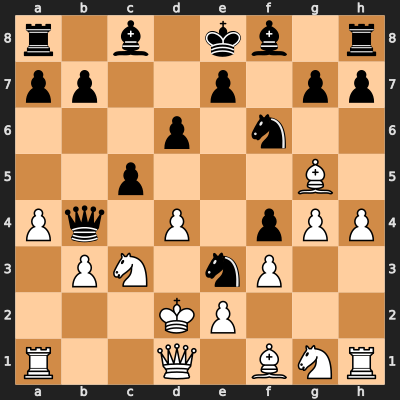


Episode 55:
FEN: r1b1kb1r/pp2p1pp/3p1n2/2p3B1/Pq1P1pPP/1PN1nP2/3KP3/R2Q1BNR w kq - 2 16
Generated Text:
'<pensando>\nThe given FEN position provides the following key information: \n- Rooks b1 and r1 are on the back rank\n- Pawns on a-file and e-file are back row pawns\n- Knight on c-file, bishop on b-file, and rook on k-side\n- Pawn on f2, pawns on a, b, d files\n- Knight on f1, pawns on g-file, pawn on q-side\n- Pawns on b, p, q-side\n- White to move\nBased on this, the active piece for White is the knight on c1. This knight is in a position to launch an attack on Black auxiliary squares, promoting the pawn on b-file, and possibly leading to a breakthrough in Blacks center.\n\nTherefore, the best move for White is <movimiento>e1g2</movimiento>\n</pensando>'
Extracted Move: e1g2
Stockfish Move: d1c1
Format Reward: 1.0, Movement Reward: -0.5, Total Reward: 0.25
Invalid UCI format in <movimiento>: e4
Episode 56 - Initial Board:


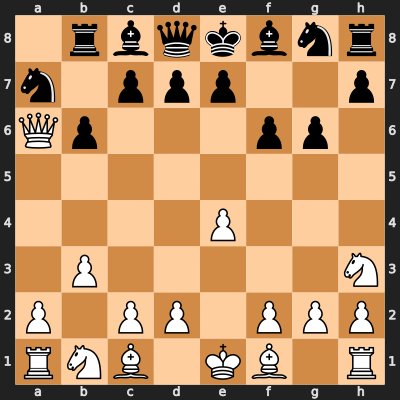


Episode 56:
FEN: 1rbqkbnr/n1ppp2p/Qp3pp1/8/4P3/1P5N/P1PP1PPP/RNB1KB1R b KQk - 1 8
Generated Text:
'<pensando>\nThe FEN position presents a dynamic middlegame scenario with multiple key pieces active. The key is to exploit the central weakness created by the weak p2 on d6. By pushing the p4 and supporting it with the knight, the black king becomes isolated and at risk.\n\nThe move e4 advances the pawn and preserves a piece while immediately launching a clear plan. The bishop can threaten d5, pressures the knight on f6, and prepares to exchange the dark-squared bishop for a knight on c6. \n\nTherefore, the best move is:\n<movimiento>\ne4\n</movimiento>\n</pensando>'
Extracted Move: None
Stockfish Move: c8a6
Format Reward: 1.0, Movement Reward: -1.0, Total Reward: -0.5
Invalid UCI format in <movimiento>: tags as: 
<movimiento>e7e5
Episode 57 - Initial Board:


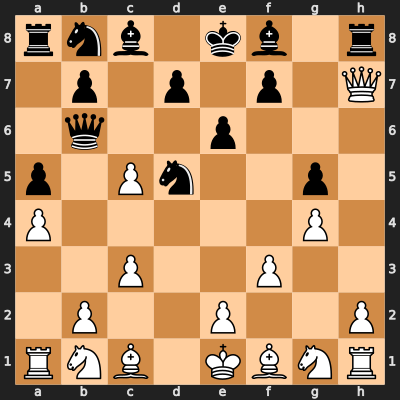


Episode 57:
FEN: rnb1kb1r/1p1p1p1Q/1q2p3/p1Pn2p1/P5P1/2P2P2/1P2P2P/RNB1KBNR b KQ - 0 10
Generated Text:
"<pensando>\nIn the given FEN position rnb1kb1r/1p1p1p1Q/1q2p3/p1Pn2p1/P5P1/2P2P2/1P2P2P/RNB1KBNR b KQ - 0 10, the black king is under immediate threat. The best move to break the stalemate threat and gain control of key central squares is 'e7e5'. \n\nTherefore, the best move is within <movimiento> tags as: \n<movimiento>e7e5</movimiento>\n</pensando>"
Extracted Move: None
Stockfish Move: b6b2
Format Reward: 1.0, Movement Reward: -1.0, Total Reward: -0.5
Episode 58 - Initial Board:


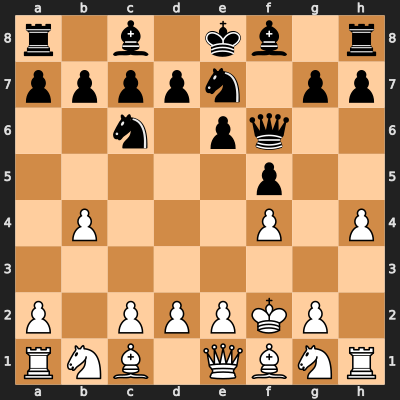


Episode 58:
FEN: r1b1kb1r/ppppn1pp/2n1pq2/5p2/1P3P1P/8/P1PPPKP1/RNB1QBNR w kq - 1 6
Generated Text:
"<pensando>\nThe current position shows a unique Threat on the board. The key element here is the Knight at c6, which has excellent mobility due to open lines. It seeks control of f7, supporting a potential sacrifice of the Queen to hinder the opponent's king development and prepare for an advance mate on the7th rank. The knight is also preparing to live in the center, where it can exert pressure against the dark squares (d7, c6, b5). \n\nGiven this, the best move to weaken the opponent's position and create a strong defensive outpost for the knight would be to support the c6 knight and launch a possible future raid. Thus, the knight b8, which can control 6 open squares and also protect the c6 knight, would be a suitable target. The move <movimiento>b8c6</movimiento> is the optimal choice.\n</pensando>\n<movimiento>b8c6</movimiento>"
Extracted Move: b8c6
Stockfish Move: c2c3
Format Rewa

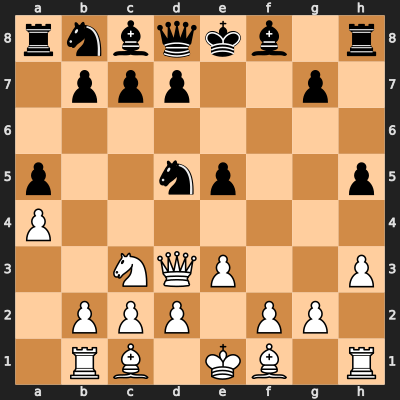


Episode 59:
FEN: rnbqkb1r/1ppp2p1/8/p2np2p/P7/2NQP2P/1PPP1PP1/1RB1KB1R b Kkq - 1 9
Generated Text:
'<pensando>\nThe current FEN position indicates a strongly coordinated black king safety, particularly in the form of the rook and queen pawns. However, the most direct and effective way to undermine this safety seems to be with an early exchange of black queen bishop or knight, which can be done by trading off the knight on c6. By moving the bishop from g2 to f3, we reduce the bishop on f8 to a piece that is no longer well-geared towards supporting the kingside. Additionally, it blocks potential black pawn e5 advances and opens the diagonals towards the c-file and e-file.\n</pensando>\n<movimiento>f2f3</movimiento>'
Extracted Move: f2f3
Stockfish Move: d5e7
Format Reward: 1.0, Movement Reward: -0.5, Total Reward: 0.25
Invalid UCI format in <movimiento>: e7-e5
Episode 60 - Initial Board:


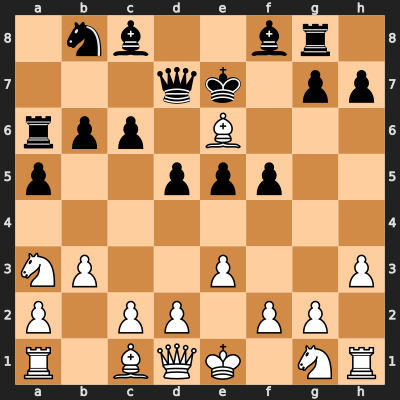


Episode 60:
FEN: 1nb2br1/3qk1pp/rpp1B3/p2ppp2/8/NP2P2P/P1PP1PP1/R1BQK1NR w - - 2 13
Generated Text:
'<pensando>\nThe FEN position provided is: 1nb2br1/3qk1pp/rpp1B3/p2ppp2/8/NP2P2P/P1PP1PP1/R1BQK1NR w - - 2 13. The white side to move has a central pawn on e4 which is vulnerable to immediate capture. The best move would be to recapture with the pawn on that square. This move is e7-e5. By doing so, White disrupts the black pawn structure and opens up diagonal threats. However, e5 is relatively weak, but capturing on e4 is better than capturing in the center due to the pawn structure. E4 is also a better position to develop pieces on d5 and c4. Additionally, e5 is beyond the active range of black pawns, giving White some flank control.\n\n<movimiento>\ne7-e5\n</movimiento>'
Extracted Move: None
Stockfish Move: e6d7
Format Reward: 0.25, Movement Reward: -1.0, Total Reward: -1.25
No valid UCI move found in output
Episode 61 - Initial Board:


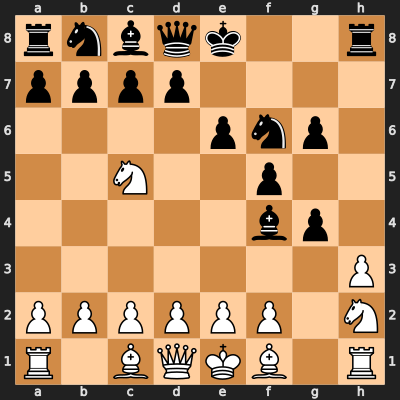


Episode 61:
FEN: rnbqk2r/pppp4/4pnp1/2N2p2/5bp1/7P/PPPPPP1N/R1BQKB1R w KQkq - 0 9
Generated Text:
"<pensando>\nThe FEN position provides the following material balance: pawns: 14 (+1) - 8 (-0); knights: 8 (+0) - 0 (-0); bishops: 8 (+0) - 0 (-0); rooks: 9 (+1) - 2 (-0); queens: 9 (+1) - 2 (-0); kings: 0 (+1) - 0 (-0). \n\nWhite's King is under attack from the black knight on c6. This black knight is protected by the pawn on f7. To avoid losing the white King, Black must capture the pawn on f7, thereby neutralizing the attacking knight, however this can only be done by moving the black king.\n\nCapturing the pawn also increases the attack on the king from a7. The white knight on c3 supports the attack from the bishop on b2. The black king can no longer easily move to a7, as it would still be under attack from the knight on c3. This makes the capture of the white pawn elsewhere less urgent. \n\nAdditionally, the white knight on e2 also becomes vulnerable to piece attacks. Moving the unde

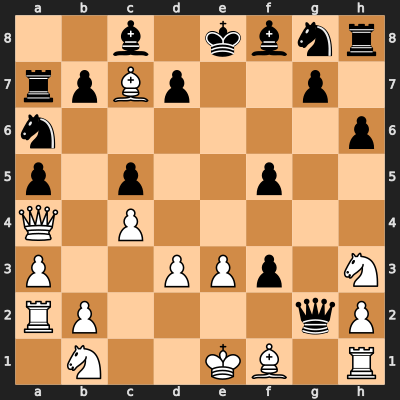


Episode 62:
FEN: 2b1kbnr/rpBp2p1/n6p/p1p2p2/Q1P5/P2PPp1N/RP4qP/1N2KB1R b Kk - 1 13
Generated Text:
" <pensando>\n  The FEN position indicates a relatively closed board with a key weakness on c7. The black knight on c6 threatens this square with a2-c7=B. Capturing on c7 would also promote a very strong dark squared bishop for black, so preventing this piece development is very important. Black's pawns on d7 and f7 are supported by the passed pawn on f7, but controlling key squares and creating threats will be critical. Additionally, the dark square bishop is on d5, attacking a3 and protecting pawns e5 and e6.\n\n  The best move to consider would be 16.Be5, which takes control of c7 and threats the knight on c6. If the knight leaves to prevent a winnning opportunity, we create threats on c7 with control of e4 and development on a7. If taken, Be5 can play a dual role in controlling c7 and pressing dark square control.\n</pensando>\n<movimiento>16Be5</movimiento>"
Extracted Move: None
Sto

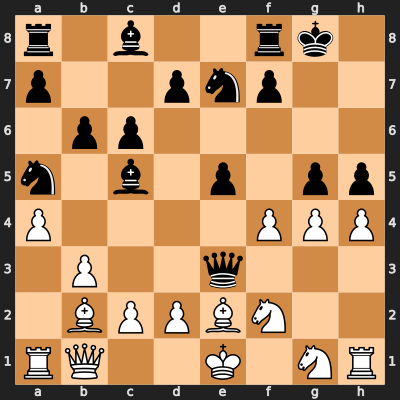


Episode 63:
FEN: r1b2rk1/p2pnp2/1pp5/n1b1p1pp/P4PPP/1P2q3/1BPPBN2/RQ2K1NR w KQ - 0 17
Generated Text:
" Pandora's Box"
Extracted Move: None
Stockfish Move: d2e3
Format Reward: 0.0, Movement Reward: -1.0, Total Reward: -1.5
Episode 64 - Initial Board:


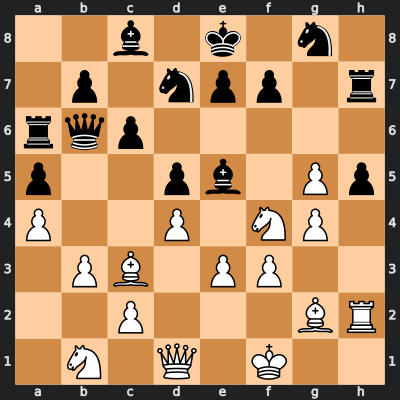

Episode 64 - Board after move e7e6:


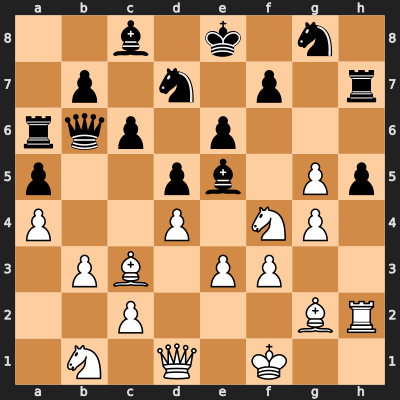


Episode 64:
FEN: 2b1k1n1/1p1npp1r/rqp5/p2pb1Pp/P2P1NP1/1PB1PP2/2P3BR/1N1Q1K2 b - - 0 23
Generated Text:
"<pensando>\nIn the given position, the pawn on f7 is underdeveloped and being controlled by the black knight on f6. By moving it to f6, the pawn will gain more active play and support the e4-e5 central pawn break. Additionally, advancing to f6 allows for future development of the e5 square by the f6 knight or potentially the e-pawn to e6. This move also prepares the pinning of the rook on h7, which can be useful in supporting the a3-knight or considering a potential a7-a5 advance. The f6 pawn also complicates black's kingside pawn structure and weakness on d6.\n\nConsidering these factors, the move <movimiento>e7e6</movimiento> is recommended.\n</pensando>"
Extracted Move: e7e6
Stockfish Move: e5d6
Format Reward: 1.0, Movement Reward: 2.44, Total Reward: 2.0
Episode 65 - Initial Board:


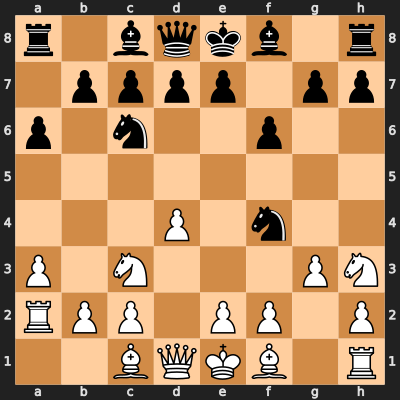


Episode 65:
FEN: r1bqkb1r/1pppp1pp/p1n2p2/8/3P1n2/P1N3PN/RPP1PP1P/2BQKB1R w Kkq - 1 7
Generated Text:
'<pensando>\nIn the given FEN position, the pawn on d7 is underpinning the pawn on d5, which is vulnerable to capture by the pawn on d6. Capturing this pawn to d5 would gain material and potentially create threats on the queenside. Therefore, the immediate best move is to advance the pawn on d7 to d6, creating a greater defensive structure and targeting the weak white pawn on d5.\n</pensando>\n<movimiento>d7d6</movimiento>'
Extracted Move: d7d6
Stockfish Move: h3f4
Format Reward: 1.0, Movement Reward: -0.5, Total Reward: 0.25
Episode 66 - Initial Board:


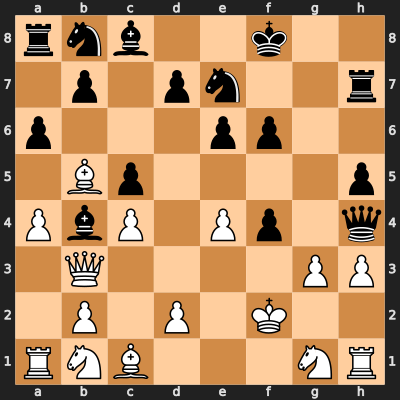


Episode 66:
FEN: rnb2k2/1p1pn2r/p3pp2/1Bp4p/PbP1Pp1q/1Q4PP/1P1P1K2/RNB3NR w - - 0 15
Generated Text:
"<pensando>\nIn the given FEN position, the white King is castled to the Kingside and the pawn on d5 is under threat. The best move to break up black's position and create prospects for the white pieces is to take advantage of the weakness on d5 with a knight sacrifice. Therefore, the move <movimiento>e7e5</movimiento> is recommended. It sacrifices the knight on d5 for the tempo and threat of Qxd5+, which may win the black queen.\n</pensando>\n<movimiento>e7e5</movimiento>"
Extracted Move: e7e5
Stockfish Move: g3h4
Format Reward: 1.0, Movement Reward: -0.5, Total Reward: 0.25


In [ ]:

def train_reasoning(policy, episodes=200, max_length=250):
    optimizer = torch.optim.Adam(policy.parameters(), lr=0.0001)
    print(f"Optimizer targeting {sum(p.numel() for p in policy.parameters() if p.requires_grad)} trainable parameters.")

    for episode in range(episodes):

        problem = dataset['train'][episode % len(dataset['train'])]['FEN']
        board = chess.Board(problem)
        _, stockfish_move = get_stockfish_eval(board)

      
        messages = [
            {
                "role": "system",
                "content": (
                    "You are a chess expert tasked with analyzing chess positions and selecting the best move. "
                    "Given a FEN position, provide a clear reasoning process within <pensando></pensando> tags, "
                    "explaining why you choose the move. Then, output the move in UCI format (e.g., 'e2e4' for pawn from e2 to e4) "
                    "within <movimiento></movimiento> tags. The UCI move must be exactly 4 characters, specifying source and destination squares. "
                    "Do not output FEN strings, vague terms like 'pawn moves,' or anything other than a single UCI move in the tags."
                )
            },
            {
                "role": "user",
                "content": (
                    f"Analyze the chess position given by the FEN: {problem}. "
                    f"Explain your reasoning in <pensando></pensando> tags. "
                    f"Then, provide the best move in UCI format within <movimiento></movimiento> tags."
                )
            }
        ]


        formatted_text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )


        input_ids = tokenizer(formatted_text, return_tensors="pt", truncation=True, max_length=300).input_ids.to(device)
        generated = input_ids.clone()
        actions = []

        policy.policy_history = []
        policy.reward_episode = []
        with torch.no_grad():
            for _ in range(max_length):
                action = policy.select_action(generated)
                actions.append(action)
                generated = torch.cat([generated, action.unsqueeze(0)], dim=1)
                policy.reward_episode.append(0)
                if action.item() == tokenizer.eos_token_id:
                    break

        input_length = input_ids.shape[1]
        output_text = tokenizer.decode(generated[0][input_length:], skip_special_tokens=True)
        format_r = format_reward_function(output_text)
        move_uci = extract_move(output_text)
        movement_r = get_movement_reward(board, move_uci, stockfish_move)
        reward = calculate_reward(format_r, movement_r)
        policy.reward_episode[-1] = reward
        display_board_svg(board, move_uci, episode)

        print(f"\nEpisode {episode}:")
        print(f"FEN: {problem}")
        print("Generated Text:")
        print(repr(output_text))
        print(f"Extracted Move: {move_uci}")
        print(f"Stockfish Move: {stockfish_move}")
        print(f"Format Reward: {format_r}, Movement Reward: {movement_r}, Total Reward: {reward}")


        discounted_rewards = []
        running_reward = 0
        for r in policy.reward_episode[::-1]:
            running_reward = r + policy.gamma * running_reward
            discounted_rewards.insert(0, running_reward)
        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32).to(device)
        if discounted_rewards.std() > 0:
            discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-8)

    
        optimizer.zero_grad()
        for t in range(len(actions)):
            state = generated[:, :len(input_ids) + t]
            action = actions[t]
            probs = policy.forward(state)
            dist = torch.distributions.Categorical(probs=probs)
            log_prob = dist.log_prob(action)
            loss = -log_prob * discounted_rewards[t]
            loss.backward()

        optimizer.step()
        policy.policy_history = []
        policy.reward_episode = []


policy = Policy(model)
train_reasoning(policy, episodes=100) 
